# Urban Crime Analytics & Geospatial Intelligence System

# 1. Research Topic and Background
## 1.1. Introduction
This study examines arrest patterns across two major American metropolitan police departments—the New York Police Department (NYPD) and the Los Angeles Police Department (LAPD)—from 2010 to 2019. Understanding temporal and spatial crime patterns is crucial for effective law enforcement resource allocation, community safety initiatives, and evidence-based policy development. Recent research by David Weisburd et al.[1] has highlighted the importance of examining micro-geographic concentrations of crime, while John MacDonald [3] demonstrated how policy changes have influenced arrest patterns in major urban centers. This analysis builds upon these works by comparing how arrest patterns manifest differently in America's two largest cities.

## 1.2. Research Questions
- How do temporal arrest patterns differ between NYPD and LAPD, and what might explain these differences?
- What geographic clustering patterns emerge in arrests, and how do these reflect the different urban structures of New York and Los Angeles?
- How have arrest patterns evolved over the 2010-2019 period, and what policy implications might this suggest?

## 1.3. Key Criminological Concepts
1. Temporal crime patterns: Cyclical variations in criminal activity based on time of day, day of week, month, or year
2. Crime hotspots: Geographic areas with disproportionately high concentrations of criminal activity
3. Enforcement discretion: The latitude officers have in deciding whether to make arrests for certain offenses
4. Broken windows policing: Enforcement strategy targeting minor offenses to prevent more serious crime
5. Density-crime relationship: Theoretical frameworks linking population density to crime rates and patterns
6. Enforcement density: The concentration of police resources relative to population and geography

## 1.4. Data Sources
The datasets used in this analysis come from publicly available police arrest records from the NYPD and LAPD, standardized to allow for direct comparison. The NYPD dataset (https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u/about_data) contains more than 5 million records of which only 3,414,946 records are relevant for our analysis, while the LAPD dataset(https://data.lacity.org/Public-Safety/Arrest-Data-from-2010-to-2019/yru6-6re4/about_data) contains 1,320,817 records over the same preiod of time.

These data were originally collected for administrative and operational purposes by each department, then released as part of open data initiatives to increase transparency in policing. While useful for research, it's important to note these datasets reflect enforcement actions rather than actual crime rates—a crucial distinction when interpreting patterns.

## 1.5. Ethical and Legal Considerations
This analysis uses de-identified, aggregated data to protect individual privacy. However, historical biases in policing that have disproportionately affected minority communities must be acknowledged when interpreting these results. As Sampson and Loeffler [4] note, arrest concentrations often reflect a complex interplay of actual crime patterns, policy decisions, and potential enforcement biases.

## 1.6. Data Validity Assessment
While these datasets are comprehensive, several potential limitations exist:
1. Arrest data may reflect enforcement priorities rather than actual crime rates
2. Geocoding accuracy varies, particularly in densely populated areas
3. Cross-city comparisons require careful interpretation due to differences in legal codes, department policies, and reporting practices

# 2. Data Overview & Pre-processing
## 2.0 Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from datetime import datetime
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
import contextily as ctx

## 2.1. File I/O Operations

In [5]:
# Function to load data from CSV files with robust error handling
def load_data(filepath):
    try:
        df = pd.read_csv(filepath, low_memory=False)
        print(f"Data successfully loaded from {filepath}")
        return df
    except FileNotFoundError:
        # Handle case where the file doesn't exist at the specified path
        print(f"Error: File not found at {filepath}")
        return None
    except pd.errors.ParserError:
        # Handle case where the file exists but cannot be parsed as CSV
        print(f"Error: Unable to parse CSV file at {filepath}. Check file format.")
        return None
    except Exception as e:
        # Catch any other unexpected errors during loading
        print(f"An unexpected error occurred while loading {filepath}: {e}")
        return None

# Save a pandas DataFrame to a CSV file with error handling.
def save_dataframe_to_csv(df, filename):
    try:
        # Save DataFrame to CSV without index column
        df.to_csv(filename, index=False)
        print(f"\n--- Saving Progress ---")
        print(f"Done! The progress saved here: '{filename}'.")

    except PermissionError:
        # Handle case where file can't be written due to permissions
        print(f"PermissionError: Unable to save '{filename}'. Please close the file if it's open and try again.")
    except FileNotFoundError:
        # Handle case where the directory doesn't exist
        print(f"FileNotFoundError: Directory for '{filename}' not found.")
    except Exception as e:
        # Catch any other unexpected errors during saving
        print(f"An unexpected error occurred while saving '{filename}': {e}")

# Load NYPD and LAPD arrest datasets
nypd_df = load_data("RAW_NYPD_Arrest_Data.csv")
lapd_df = load_data("RAW_LAPD_Arrest_Data.csv")

Error: File not found at RAW_NYPD_Arrest_Data.csv
Error: File not found at RAW_LAPD_Arrest_Data.csv


## 2.2. Data Cleaning

In [24]:
def rename_nypd_columns(df):
    column_mapping = {
        'ARREST_KEY': 'ID',
        'ARREST_DATE': 'Arrest_Date',
        'PD_CD': 'PD_Code',
        'PD_DESC': 'Offense_Description',
        'KY_CD': 'KY_Code',
        'OFNS_DESC': 'Offense_Category',
        'LAW_CODE': 'Law_Code',
        'LAW_CAT_CD': 'Law_Category',
        'ARREST_BORO': 'Arrest_Borough',
        'ARREST_PRECINCT': 'Arrest_Precinct',
        'JURISDICTION_CODE': 'Jurisdiction_Code',
        'AGE_GROUP': 'Age_Group',
        'PERP_SEX': 'Perp_Sex',
        'PERP_RACE': 'Perp_Race',
        'X_COORD_CD': 'X_Coordinate',
        'Y_COORD_CD': 'Y_Coordinate',
        'Latitude': 'Latitude',
        'Longitude': 'Longitude',
        'Lon_Lat': 'Location_Point'
    }

    # Rename columns
    df.rename(columns=column_mapping, inplace=True)

    return df

def rename_lapd_columns(df):
    column_mapping = {
    'Report ID': 'ID',
    'Report Type': 'Report_Type',
    'Arrest Date': 'Arrest_Date',
    'Time': 'Arrest_Time',
    'Area ID': 'Area_ID',
    'Area Name': 'Area_Name',
    'Reporting District': 'Reporting_District',
    'Age': 'Age',
    'Sex Code': 'Perp_Sex_Code',
    'Descent Code': 'Perp_Descent_Code',
    'Charge Group Code': 'Charge_Group_Code',
    'Charge Group Description': 'Charge_Group_Description',
    'Arrest Type Code': 'Arrest_Type_Code',
    'Charge': 'Charge_Code',
    'Charge Description': 'Charge_Description',
    'Disposition Description': 'Disposition_Description',
    'Address': 'Arrest_Address',
    'Cross Street': 'Cross_Street',
    'LAT': 'Latitude',
    'LON': 'Longitude',
    'Location': 'Location_Point',
    'Booking Date': 'Booking_Date',
    'Booking Time': 'Booking_Time',
    'Booking Location': 'Booking_Location',
    'Booking Location Code': 'Booking_Location_Code'
    }
    # Rename columns
    df.rename(columns=column_mapping, inplace=True)

    return df

nypd_df = rename_nypd_columns(nypd_df)
lapd_df = rename_lapd_columns(lapd_df)

In [25]:
# This function cleans NYPD
def clean_nypd_data(df):
    if nypd_df is None:
        return None

    # Handle missing values
    # Based on statistics, PD_Code, KY_Code, and Law_Category have missing values
    print(f"Missing values in NYPD dataset before cleaning:\n{df.isnull().sum()}")

    # Fill PD_Code missing values (categorical code)
    df['PD_Code'] = df['PD_Code'].fillna(-1)

    # Fill KY_Code missing values
    df['KY_Code'] = df['KY_Code'].fillna(-1)

    # Handle missing values in Law_Category and Law_Code
    df['Law_Category'] = df['Law_Category'].fillna('Unknown')
    df['Law_Code'] = df['Law_Code'].fillna('Unknown')

    # Handle other columns with missing values
    df['Offense_Description'] = df['Offense_Description'].fillna('Not Specified')
    df['Offense_Category'] = df['Offense_Category'].fillna('Not Specified')
    df['Arrest_Borough'] = df['Arrest_Borough'].fillna('Unknown')

    # Handle Age_Group - set missing or invalid to 'UNKNOWN'
    df['Age_Group'] = df['Age_Group'].fillna('UNKNOWN')

    # Convert datetime string to datetime object (assuming standard format)
    try:
        df['Arrest_Date'] = pd.to_datetime(df['Arrest_Date'])
        # Add separate columns for date components
        df['Arrest_Year'] = df['Arrest_Date'].dt.year
        df['Arrest_Month'] = df['Arrest_Date'].dt.month
        df['Arrest_Day'] = df['Arrest_Date'].dt.day

    except Exception as e:
        print(f"Error converting arrest date: {e}")

    # Handle coordinate missing values
    for coord in ['X_Coordinate', 'Y_Coordinate', 'Latitude', 'Longitude']:
        df[coord] = df[coord].fillna(0)

    print(f"Missing values in NYPD dataset after cleaning:\n{df.isnull().sum()}")
    return df

nypd_df = clean_nypd_data(nypd_df)

Missing values in NYPD dataset before cleaning:
ID                         0
Arrest_Date                0
PD_Code                  876
Offense_Description     9169
KY_Code                 9756
Offense_Category        9169
Law_Code                 196
Law_Category           23600
Arrest_Borough             8
Arrest_Precinct            0
Jurisdiction_Code         10
Age_Group                 17
Perp_Sex                   0
Perp_Race                  0
X_Coordinate               1
Y_Coordinate               1
Latitude                   1
Longitude                  1
Location_Point             1
dtype: int64
Missing values in NYPD dataset after cleaning:
ID                      0
Arrest_Date             0
PD_Code                 0
Offense_Description     0
KY_Code                 0
Offense_Category        0
Law_Code                0
Law_Category            0
Arrest_Borough          0
Arrest_Precinct         0
Jurisdiction_Code      10
Age_Group               0
Perp_Sex                0
Per

In [26]:
# Clean the LAPD dataset by handling missing values, standardizing formats
def clean_lapd_data(lapd_df):
    if lapd_df is None:
        return None

    # Create a copy to avoid modifying the original dataframe
    df = lapd_df.copy()

    # Handle missing values
    print(f"Missing values in LAPD dataset before cleaning:\n{df.isnull().sum()}")

    # Fill missing values in Charge related columns
    df['Charge_Group_Code'] = df['Charge_Group_Code'].fillna(-1)
    df['Charge_Group_Description'] = df['Charge_Group_Description'].fillna('Not Specified')
    df['Charge_Code'] = df['Charge_Code'].fillna('Unknown')
    df['Charge_Description'] = df['Charge_Description'].fillna('Not Specified')

    # Handle missing values in Arrest_Type_Code and Disposition_Description
    df['Arrest_Type_Code'] = df['Arrest_Type_Code'].fillna('Unknown')
    df['Disposition_Description'] = df['Disposition_Description'].fillna('Unknown')

    # Handle missing values in Arrest_Time
    df['Arrest_Time'] = df['Arrest_Time'].fillna(-1)

    # Handle missing values in Cross_Street
    df['Cross_Street'] = df['Cross_Street'].fillna('Not Specified')

    # Handle booking related missing values
    df['Booking_Date'] = df['Booking_Date'].fillna('Unknown')
    df['Booking_Time'] = df['Booking_Time'].fillna(-1)
    df['Booking_Location'] = df['Booking_Location'].fillna('Unknown')
    df['Booking_Location_Code'] = df['Booking_Location_Code'].fillna(-1)

    # Clean Age data - remove invalid ages (negative or unreasonably high)
    invalid_age_mask = (df['Age'] < 0) | (df['Age'] > 100)
    df.loc[invalid_age_mask, 'Age'] = np.nan
    invalid_count = invalid_age_mask.sum()
    if invalid_count > 0:
        print(f"Set {invalid_count} invalid LAPD age values to NaN")

    # Convert datetime string to datetime object
    try:
        df['Arrest_Date'] = pd.to_datetime(df['Arrest_Date'])
        # Add separate columns for date components
        df['Arrest_Year'] = df['Arrest_Date'].dt.year
        df['Arrest_Month'] = df['Arrest_Date'].dt.month
        df['Arrest_Day'] = df['Arrest_Date'].dt.day
    except Exception as e:
        print(f"Error converting arrest date: {e}")

    # Check for duplicates
    duplicate_count = df.duplicated().sum()
    print(f"Found {duplicate_count} duplicate rows in LAPD dataset")
    if duplicate_count > 0:
        df = df.drop_duplicates()

    print(f"Missing values in LAPD dataset after cleaning:\n{df.isnull().sum()}")
    return df

lapd_df = clean_lapd_data(lapd_df)

Missing values in LAPD dataset before cleaning:
ID                               0
Report_Type                      0
Arrest_Date                      0
Arrest_Time                    196
Area_ID                          0
Area_Name                        0
Reporting_District               0
Age                              0
Perp_Sex_Code                    0
Perp_Descent_Code                0
Charge_Group_Code            77605
Charge_Group_Description     78134
Arrest_Type_Code            105831
Charge_Code                      1
Charge_Description           77605
Disposition_Description     105829
Arrest_Address                   0
Cross_Street                567580
Latitude                         0
Longitude                        0
Location_Point                   0
Booking_Date                414552
Booking_Time                414554
Booking_Location            414790
Booking_Location_Code       414587
dtype: int64
Found 0 duplicate rows in LAPD dataset
Missing values in LAPD da

In [36]:
# Convert a numeric age to the corresponding NYPD age group category
def convert_numeric_age_to_category(age):
    if pd.isna(age) or age < 0:
        return 'UNKNOWN'

    if age < 18:
        return '<18'
    elif 18 <= age <= 24:
        return '18-24'
    elif 25 <= age <= 44:
        return '25-44'
    elif 45 <= age <= 64:
        return '45-64'
    elif age >= 65:
        return '65+'
    else:
        return 'UNKNOWN'

# Standardize age categories across both datasets using NYPD age categories as standard.
def standardize_age_categories(nypd_df, lapd_df):
    # Create copies to avoid modifying the originals
    nypd = nypd_df.copy() if nypd_df is not None else None
    lapd = lapd_df.copy() if lapd_df is not None else None

    # Get standard age categories
    standard_categories = ['<18', '18-24', '25-44', '45-64', '65+', 'UNKNOWN']

    if nypd is not None:
        # Filter out invalid age groups in NYPD dataset
        valid_age_mask = nypd['Age_Group'].isin(standard_categories)
        # For invalid age groups, set to 'UNKNOWN'
        nypd.loc[~valid_age_mask, 'Age_Group'] = 'UNKNOWN'
        # Create a standardized age category column
        nypd['Age_Category_Std'] = nypd['Age_Group']

        # Calculate how many records had invalid age data
        invalid_count = (~valid_age_mask).sum()
        if invalid_count > 0:
            print(f"Set {invalid_count} invalid NYPD age values to 'UNKNOWN'")

    if lapd is not None:
        # Convert LAPD numeric ages to NYPD categories
        lapd['Age_Category_Std'] = lapd['Age'].apply(convert_numeric_age_to_category)

        # Calculate how many records were mapped to each category
        category_counts = lapd['Age_Category_Std'].value_counts()
        print("LAPD ages mapped to NYPD categories:")
        for category, count in category_counts.items():
            print(f"  {category}: {count}")

    return nypd, lapd

# Standardize gender/sex columns across both datasets
def standardize_gender(nypd_df, lapd_df):
    # Create copies to avoid modifying the originals
    nypd = nypd_df.copy() if nypd_df is not None else None
    lapd = lapd_df.copy() if lapd_df is not None else None

    if nypd is not None:
        # Map NYPD gender categories
        gender_map = {
            'M': 'Male',
            'F': 'Female',
            'U': 'Unknown'
        }
        nypd['Gender_Std'] = nypd['Perp_Sex'].map(gender_map)
        nypd['Gender_Std'] = nypd['Gender_Std'].fillna('Unknown')

    if lapd is not None:
        # Map LAPD gender categories (adjust based on actual categories)
        gender_map = {
            'M': 'Male',
            'F': 'Female',
            'X': 'Unknown'
        }
        lapd['Gender_Std'] = lapd['Perp_Sex_Code'].map(gender_map)
        lapd['Gender_Std'] = lapd['Gender_Std'].fillna('Unknown')

    return nypd, lapd

#Standardize race and ethnicity columns across both datasets
def standardize_race_ethnicity(nypd_df, lapd_df):

    # Create copies to avoid modifying the originals
    nypd = nypd_df.copy() if nypd_df is not None else None
    lapd = lapd_df.copy() if lapd_df is not None else None

    if nypd is not None:
        # Map NYPD race categories
        race_map = {
            'BLACK': 'Black',
            'WHITE': 'White',
            'WHITE HISPANIC': 'Hispanic',
            'BLACK HISPANIC': 'Hispanic',
            'ASIAN / PACIFIC ISLANDER': 'Asian/Pacific Islander',
            'AMERICAN INDIAN/ALASKAN NATIVE': 'Native American',
            'UNKNOWN': 'Unknown'
        }
        nypd['Race_Std'] = nypd['Perp_Race'].map(race_map)
        nypd['Race_Std'] = nypd['Race_Std'].fillna('Unknown')

    if lapd is not None:
        # Map LAPD descent codes
        race_map = {
            'H': 'Hispanic',
            'B': 'Black',
            'W': 'White',
            'A': 'Asian/Pacific Islander',
            'C': 'Asian/Pacific Islander',
            'J': 'Asian/Pacific Islander',
            'K': 'Asian/Pacific Islander',
            'L': 'Asian/Pacific Islander',
            'V': 'Asian/Pacific Islander',
            'F': 'Asian/Pacific Islander',
            'D': 'Asian/Pacific Islander',
            'I': 'Native American',
            'O': 'Other',
            'X': 'Unknown',
            'Z': 'Unknown'
        }
        lapd['Race_Std'] = lapd['Perp_Descent_Code'].map(race_map)
        lapd['Race_Std'] = lapd['Race_Std'].fillna('Unknown')

    return nypd, lapd

# Create standardized offense categories across both datasets
def standardize_offense_categories(nypd_df, lapd_df):

    # Create copies to avoid modifying the originals
    nypd = nypd_df.copy() if nypd_df is not None else None
    lapd = lapd_df.copy() if lapd_df is not None else None

    # Define common high-level offense categories
    common_categories = [
        'Violent Crime',
        'Property Crime',
        'Drug Offense',
        'Public Order',
        'Traffic Violation',
        'Weapon Offense',
        'Other'
    ]

    if nypd is not None:
        nypd['Offense_Std'] = nypd['Offense_Category']

        offense_map = {
            'ROBBERY': 'Violent Crime',
            'ASSAULT': 'Violent Crime',
            'BURGLARY': 'Property Crime',
            'GRAND LARCENY': 'Property Crime',
            'DANGEROUS DRUGS': 'Drug Offense',
            'DANGEROUS WEAPONS': 'Weapon Offense',
            'FELONY ASSAULT': 'Violent Crime',
            'PETIT LARCENY': 'Property Crime',

        }

        # Apply mapping
        nypd['Offense_Std'] = nypd['Offense_Category'].map(lambda x:
            next((v for k, v in offense_map.items() if k in str(x).upper()), 'Other'))

    if lapd is not None:
        # Map LAPD Charge_Group_Description to common categories
        offense_map = {
            'ROBBERY': 'Violent Crime',
            'ASSAULT': 'Violent Crime',
            'BURGLARY': 'Property Crime',
            'THEFT': 'Property Crime',
            'NARCOTIC': 'Drug Offense',
            'WEAPON': 'Weapon Offense',
            'TRAFFIC': 'Traffic Violation',
        }

        # Apply mapping
        lapd['Offense_Std'] = lapd['Charge_Group_Description'].map(lambda x:
            next((v for k, v in offense_map.items() if k in str(x).upper()), 'Other'))

    return nypd, lapd

# Create aligned datasets with common columns for comparison
def create_aligned_datasets(nypd_df, lapd_df):

    if nypd_df is None or lapd_df is None:
        print("One or both datasets are missing. Cannot create aligned datasets.")
        return None, None, []

    # Add dataset identifier columns
    nypd_df['Data_Source'] = 'NYPD'
    lapd_df['Data_Source'] = 'LAPD'

    # Define common columns that will be in the aligned datasets
    common_columns = [
        'Data_Source',
        'Arrest_Year',
        'Arrest_Month',
        'Arrest_Day',
        'Gender_Std',
        'Race_Std',
        'Age_Category_Std',  # Using standardized age categories
        'Offense_Std',
        'Latitude',
        'Longitude'
    ]

    # NYPD aligned dataset
    nypd_columns = {}
    for col in common_columns:
        if col in nypd_df.columns:
            nypd_columns[col] = nypd_df[col]
        else:
            nypd_columns[col] = pd.Series(np.nan, index=nypd_df.index)

    nypd_aligned = pd.DataFrame(nypd_columns)

    # LAPD aligned dataset
    lapd_columns = {}
    for col in common_columns:
        if col in lapd_df.columns:
            lapd_columns[col] = lapd_df[col]
        else:
            lapd_columns[col] = pd.Series(np.nan, index=lapd_df.index)

    lapd_aligned = pd.DataFrame(lapd_columns)

    print(f"\nCreated aligned datasets with {len(common_columns)} common columns")
    print(f"NYPD aligned: {nypd_aligned.shape}")
    print(f"LAPD aligned: {lapd_aligned.shape}")

    return nypd_aligned, lapd_aligned, common_columns

# Filter both datasets to include only records from years that overlap in both datasets.
def filter_datasets_by_year_range(nypd_df, lapd_df):

    if nypd_df is None or lapd_df is None:
        print("One or both datasets are missing. Cannot filter by year range.")
        return None, None

    # Ensure both datasets have the Arrest_Year column
    if 'Arrest_Year' not in nypd_df.columns or 'Arrest_Year' not in lapd_df.columns:
        print("One or both datasets are missing the 'Arrest_Year' column.")
        return nypd_df, lapd_df

    # Get unique years in each dataset
    nypd_years = set(nypd_df['Arrest_Year'].unique())
    lapd_years = set(lapd_df['Arrest_Year'].unique())

    # Remove NaT, NaN, and unreasonable years (like 0)
    nypd_years = {year for year in nypd_years if pd.notna(year) and year > 1900}
    lapd_years = {year for year in lapd_years if pd.notna(year) and year > 1900}

    # Find overlapping years
    overlapping_years = nypd_years.intersection(lapd_years)

    if not overlapping_years:
        print("No overlapping years found between datasets.")
        return nypd_df, lapd_df
    else:
        print(f"\nOverlapping years: 2010 - 2019"})

    # Filter datasets to include only records from overlapping years
    nypd_filtered = nypd_df[nypd_df['Arrest_Year'].isin(overlapping_years)].copy()
    lapd_filtered = lapd_df[lapd_df['Arrest_Year'].isin(overlapping_years)].copy()

    return nypd_filtered, lapd_filtered

# Standardize age categories using NYPD categories as standard
nypd_df, lapd_df = standardize_age_categories(nypd_df, lapd_df)

# Standardize gender
nypd_df, lapd_df = standardize_gender(nypd_df, lapd_df)

# Standardize race/ethnicity
nypd_df, lapd_df = standardize_race_ethnicity(nypd_df, lapd_df)

# Standardize offense categories
nypd_df, lapd_df = standardize_offense_categories(nypd_df, lapd_df)

# Create aligned datasets
nypd_aligned, lapd_aligned, common_columns = create_aligned_datasets(nypd_df, lapd_df)

# Filter out years that don't overlap
nypd_aligned, lapd_aligned = filter_datasets_by_year_range(nypd_aligned, lapd_aligned)


LAPD ages mapped to NYPD categories:
  25-44: 600004
  45-64: 312159
  18-24: 295370
  <18: 92725
  65+: 20559

Created aligned datasets with 10 common columns
NYPD aligned: (5725522, 10)
LAPD aligned: (1320817, 10)

Overlapping years:  {'2010 - 2019'}


### 2.2.1. Saving the progress

In [28]:
save_dataframe_to_csv(nypd_aligned, 'nypd_aligned.csv')
save_dataframe_to_csv(lapd_aligned, 'lapd_aligned.csv')


--- Saving Progress ---
Done! The progress saved here: 'nypd_aligned.csv'.

--- Saving Progress ---
Done! The progress saved here: 'lapd_aligned.csv'.


### 2.2.2. Checkpoint

In [8]:
nypd_aligned = load_data('nypd_aligned.csv')
lapd_aligned = load_data('lapd_aligned.csv')

Data successfully loaded from nypd_aligned.csv
Data successfully loaded from lapd_aligned.csv


### 2.3. Data Overview

In [9]:
# Display comprehensive overview for two dataframes side by side for comparison.
def dual_dataframe_overview(df1, df2, df1_name="DataFrame 1", df2_name="DataFrame 2", max_categories=10):

    # Create section divider for better readability
    def section_divider(title):
        width = 80
        print("\n" + "="*width)
        print(f"{title}".center(width))
        print("="*width)

    # Basic overview comparison
    section_divider("Basic DataFrame Comparison")
    comparison_data = [
        ["Rows", f"{df1.shape[0]:,}", f"{df2.shape[0]:,}"],
        ["Columns", f"{df1.shape[1]}", f"{df2.shape[1]}"],
        ["Missing cells", f"{df1.isna().sum().sum():,}", f"{df2.isna().sum().sum():,}"],
        ["Missing cells (%)", f"{df1.isna().sum().sum() / (df1.shape[0] * df1.shape[1]) * 100:.2f}%",
                              f"{df2.isna().sum().sum() / (df2.shape[0] * df2.shape[1]) * 100:.2f}%"],
        ["Duplicate rows", f"{df1.duplicated().sum():,}", f"{df2.duplicated().sum():,}"]
    ]
    print(tabulate(comparison_data, headers=["Metric", df1_name, df2_name], tablefmt='pretty'))

    # Column type comparison
    section_divider("Column Types Comparison")

    # Get column type counts for both dataframes
    df1_types = df1.dtypes.value_counts().reset_index()
    df1_types.columns = ['Data Type', 'Count']

    df2_types = df2.dtypes.value_counts().reset_index()
    df2_types.columns = ['Data Type', 'Count']

    print(f"\n{df1_name} Column Types:")
    print(tabulate(df1_types, headers='keys', tablefmt='pretty', showindex=False))

    print(f"\n{df2_name} Column Types:")
    print(tabulate(df2_types, headers='keys', tablefmt='pretty', showindex=False))

    # Compare common columns
    common_cols = set(df1.columns).intersection(set(df2.columns))
    df1_only = set(df1.columns) - common_cols
    df2_only = set(df2.columns) - common_cols

    section_divider("Column Overlap Analysis")
    print(f"Common columns: {len(common_cols)}")
    print(f"Columns only in {df1_name}: {len(df1_only)}")
    print(f"Columns only in {df2_name}: {len(df2_only)}")

    if common_cols:
        print("\nCommon columns:")
        for i, col in enumerate(sorted(common_cols), 1):
            df1_type = df1[col].dtype
            df2_type = df2[col].dtype
            same_type = "✓" if df1_type == df2_type else "✗"
            print(f"{i}. {col} ({same_type}) - Types: {df1_name}: {df1_type}, {df2_name}: {df2_type}")

    # Missing values comparison for common columns
    if common_cols:
        section_divider("Missing Values Comparison for Common Columns")
        missing_data = []

        for col in common_cols:
            df1_missing = df1[col].isna().sum()
            df1_missing_pct = (df1_missing / len(df1)) * 100

            df2_missing = df2[col].isna().sum()
            df2_missing_pct = (df2_missing / len(df2)) * 100

            missing_data.append([
                col,
                f"{df1_missing:,} ({df1_missing_pct:.2f}%)",
                f"{df2_missing:,} ({df2_missing_pct:.2f}%)"
            ])

        # Sort by the column with highest missing percentage in either dataframe
        missing_data = sorted(missing_data,
                              key=lambda x: max(
                                  float(x[1].split('(')[1].split('%')[0]),
                                  float(x[2].split('(')[1].split('%')[0])
                              ),
                              reverse=True)

        print(tabulate(missing_data, headers=["Column", f"{df1_name} Missing", f"{df2_name} Missing"],
                      tablefmt='pretty'))

    # Numeric statistics comparison for common columns
    common_numeric_cols = [col for col in common_cols
                          if pd.api.types.is_numeric_dtype(df1[col]) and
                             pd.api.types.is_numeric_dtype(df2[col])]

    if common_numeric_cols:
        section_divider("Numeric Columns Comparison")

        # Create a combined table with metrics as rows and columns as columns
        metrics = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis', 'outliers', 'outliers(%)']

        # Initialize the results table
        results_table = []

        # For each metric, collect data from both dataframes for all columns
        for metric in metrics:
            row = [metric]  # First column is the metric name

            for col in common_numeric_cols:
                # Calculate statistics for both dataframes
                df1_val = "N/A"
                df2_val = "N/A"

                # Basic statistics from describe()
                if metric in ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']:
                    if df1[col].count() > 0:
                        df1_stats = df1[col].describe()
                        df1_val = f"{df1_stats[metric]:.2f}" if metric != 'count' else f"{int(df1_stats[metric]):,}"

                    if df2[col].count() > 0:
                        df2_stats = df2[col].describe()
                        df2_val = f"{df2_stats[metric]:.2f}" if metric != 'count' else f"{int(df2_stats[metric]):,}"

                # Additional statistics
                elif metric in ['skew', 'kurtosis']:
                    if df1[col].count() > 0:
                        df1_val = f"{df1[col].skew():.2f}" if metric == 'skew' else f"{df1[col].kurtosis():.2f}"

                    if df2[col].count() > 0:
                        df2_val = f"{df2[col].skew():.2f}" if metric == 'skew' else f"{df2[col].kurtosis():.2f}"

                # Outlier calculations
                elif metric in ['outliers', 'outliers(%)']:
                    for df_name, df, val in [(df1_name, df1, df1_val), (df2_name, df2, df2_val)]:
                        if df[col].count() > 0:
                            q1 = df[col].quantile(0.25)
                            q3 = df[col].quantile(0.75)
                            iqr = q3 - q1
                            lower_bound = q1 - 1.5 * iqr
                            upper_bound = q3 + 1.5 * iqr
                            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

                            if metric == 'outliers':
                                if df_name == df1_name:
                                    df1_val = f"{len(outliers):,}"
                                else:
                                    df2_val = f"{len(outliers):,}"
                            else:  # outliers(%)
                                if df_name == df1_name:
                                    df1_val = f"{(len(outliers) / df[col].count()) * 100:.2f}%"
                                else:
                                    df2_val = f"{(len(outliers) / df[col].count()) * 100:.2f}%"

                # Combine values from both dataframes
                combined_val = f"{df1_name}: {df1_val} | {df2_name}: {df2_val}"
                row.append(combined_val)

            results_table.append(row)

        # Add column headers and print the table
        headers = ["Metric"] + common_numeric_cols
        print(tabulate(results_table, headers=headers, tablefmt='pretty'))

    # Categorical statistics comparison for common columns
    common_cat_cols = [col for col in common_cols
                      if pd.api.types.is_object_dtype(df1[col]) or
                         pd.api.types.is_object_dtype(df2[col]) or
                         pd.api.types.is_categorical_dtype(df1[col]) or
                         pd.api.types.is_categorical_dtype(df2[col])]

    if common_cat_cols:
        section_divider("Categorical Columns Comparison")

        for col in common_cat_cols:
            print(f"\nColumn: {col}")

            # Basic statistics
            df1_unique = df1[col].nunique()
            df2_unique = df2[col].nunique()

            print(f"Unique values: {df1_name}: {df1_unique:,}, {df2_name}: {df2_unique:,}")

            # Top categories comparison
            df1_top = df1[col].value_counts().head(max_categories)
            df2_top = df2[col].value_counts().head(max_categories)

            # Create a comparison table for top categories
            if max(df1_unique, df2_unique) <= max_categories * 2:  # If we can show all categories
                # Get all unique values from both dataframes
                all_values = set(df1[col].dropna().unique()).union(set(df2[col].dropna().unique()))

                comparison_data = []
                for value in sorted(all_values):
                    df1_count = df1[col].value_counts().get(value, 0)
                    df1_pct = (df1_count / df1[col].count()) * 100 if df1[col].count() > 0 else 0

                    df2_count = df2[col].value_counts().get(value, 0)
                    df2_pct = (df2_count / df2[col].count()) * 100 if df2[col].count() > 0 else 0

                    comparison_data.append([
                        str(value),
                        f"{df1_count:,} ({df1_pct:.2f}%)",
                        f"{df2_count:,} ({df2_pct:.2f}%)"
                    ])

                print(tabulate(comparison_data,
                              headers=["Value", f"{df1_name}", f"{df2_name}"],
                              tablefmt='pretty'))
            else:
                # Show top categories for each dataframe
                print(f"\nTop {max_categories} categories in {df1_name}:")
                df1_top_data = []
                for value, count in df1_top.items():
                    pct = (count / df1[col].count()) * 100
                    df1_top_data.append([str(value), f"{count:,}", f"{pct:.2f}%"])

                print(tabulate(df1_top_data, headers=["Value", "Count", "Percentage"], tablefmt='pretty'))

                print(f"\nTop {max_categories} categories in {df2_name}:")
                df2_top_data = []
                for value, count in df2_top.items():
                    pct = (count / df2[col].count()) * 100
                    df2_top_data.append([str(value), f"{count:,}", f"{pct:.2f}%"])

                print(tabulate(df2_top_data, headers=["Value", "Count", "Percentage"], tablefmt='pretty'))

            # Calculate category overlap
            if df1_unique > 0 and df2_unique > 0:
                df1_categories = set(df1[col].dropna().unique())
                df2_categories = set(df2[col].dropna().unique())
                overlap = df1_categories.intersection(df2_categories)

                print(f"\nCategory overlap: {len(overlap)} values ({len(overlap)/max(len(df1_categories), len(df2_categories)):.2f}% of the larger set)")

    # Date columns comparison
    common_date_cols = [col for col in common_cols
                       if pd.api.types.is_datetime64_dtype(df1[col]) or
                          pd.api.types.is_datetime64_dtype(df2[col])]

    if common_date_cols:
        section_divider("Temporal Data Comparison")

        for col in common_date_cols:
            print(f"\nColumn: {col}")

            # Handle cases where columns might not be datetime in both dataframes
            try:
                df1_col = pd.to_datetime(df1[col]) if not pd.api.types.is_datetime64_dtype(df1[col]) else df1[col]
                df1_min = df1_col.min()
                df1_max = df1_col.max()
                df1_range = (df1_max - df1_min).days
            except:
                df1_min, df1_max, df1_range = "N/A", "N/A", "N/A"

            try:
                df2_col = pd.to_datetime(df2[col]) if not pd.api.types.is_datetime64_dtype(df2[col]) else df2[col]
                df2_min = df2_col.min()
                df2_max = df2_col.max()
                df2_range = (df2_max - df2_min).days
            except:
                df2_min, df2_max, df2_range = "N/A", "N/A", "N/A"

            date_data = [
                ["Earliest date", df1_min, df2_min],
                ["Latest date", df1_max, df2_max],
                ["Range (days)", df1_range, df2_range]
            ]

            print(tabulate(date_data, headers=["Metric", df1_name, df2_name], tablefmt='pretty'))

    return

dual_dataframe_overview(nypd_aligned, lapd_aligned, "NYPD", "LAPD")


                           Basic DataFrame Comparison                           
+-------------------+-----------+-----------+
|      Metric       |   NYPD    |   LAPD    |
+-------------------+-----------+-----------+
|       Rows        | 3,414,946 | 1,320,817 |
|      Columns      |    10     |    10     |
|   Missing cells   |     0     |     0     |
| Missing cells (%) |   0.00%   |   0.00%   |
|  Duplicate rows   |  317,601  |  91,151   |
+-------------------+-----------+-----------+

                            Column Types Comparison                             

NYPD Column Types:
+-----------+-------+
| Data Type | Count |
+-----------+-------+
|  object   |   5   |
|   int64   |   3   |
|  float64  |   2   |
+-----------+-------+

LAPD Column Types:
+-----------+-------+
| Data Type | Count |
+-----------+-------+
|  object   |   5   |
|   int64   |   3   |
|  float64  |   2   |
+-----------+-------+

                            Column Overlap Analysis                      

### 2.3.1. Technical overview
**Dataset Size and Structure**. The comparison reveals significant differences in dataset size while maintaining identical structural characteristics:
- Size disparity: The NYPD dataset (3,414,946 rows) is approximately 2.6 times larger than the LAPD dataset (1,320,817 rows), supporting our previous observation that NYPD records significantly more arrests despite Los Angeles County's larger geographic area.
- Identical structure: Both datasets contain exactly 10 columns with matching data types (5 object/categorical, 3 integer, and 2 floating-point columns), indicating they were successfully standardized for comparative analysis.
- Data quality: Neither dataset contains missing values, suggesting the preprocessing was effective.

### 2.3.2. Results Interpretation
1. Volume difference: NYPD records significantly more arrests than LAPD (2.6x), supporting our hypothesis about population density's impact on arrest rates.
2. Geographic dispersion: LAPD arrests are more geographically dispersed, consistent with Los Angeles's lower population density and more sprawling urban layout.
3. Demographic differences: The racial composition of arrests differs substantially between departments, with NYPD arresting proportionally more Black individuals and LAPD arresting proportionally more Hispanic individuals, reflecting both demographic differences and potentially different enforcement patterns.
4. Enforcement priorities: The different distribution of offense types suggests potential differences in enforcement priorities, with NYPD showing higher proportions of drug, violent, and property crime arrests.
5. Data standardization: The identical column structure and absence of missing values suggest deliberate standardization efforts, enhancing the validity of comparative analyses.


# 3. Analysis and Visualizations
## 3.1. Temporal Crime Pattern
The primary goal of this visualization is to identify how population density might influence arrest patterns in these contrasting urban environments. New York City, with its extremely high population density, consistently shows significantly higher arrest volumes than Los Angeles, despite LA County's larger geographic area. This visualization helps explore whether this disparity is merely a function of overall population or if density itself creates unique crime dynamics.

Additional aims of this visualization include:
- Identifying whether temporal crime patterns are universal across different urban environments or are influenced by local density factors
- Examining how arrest patterns have evolved over a decade in both cities
- Detecting specific time periods where enforcement activities peak in each jurisdiction
- Providing visual evidence for how urban structure (compact vs. sprawling) might influence not just the volume but also the timing of arrests

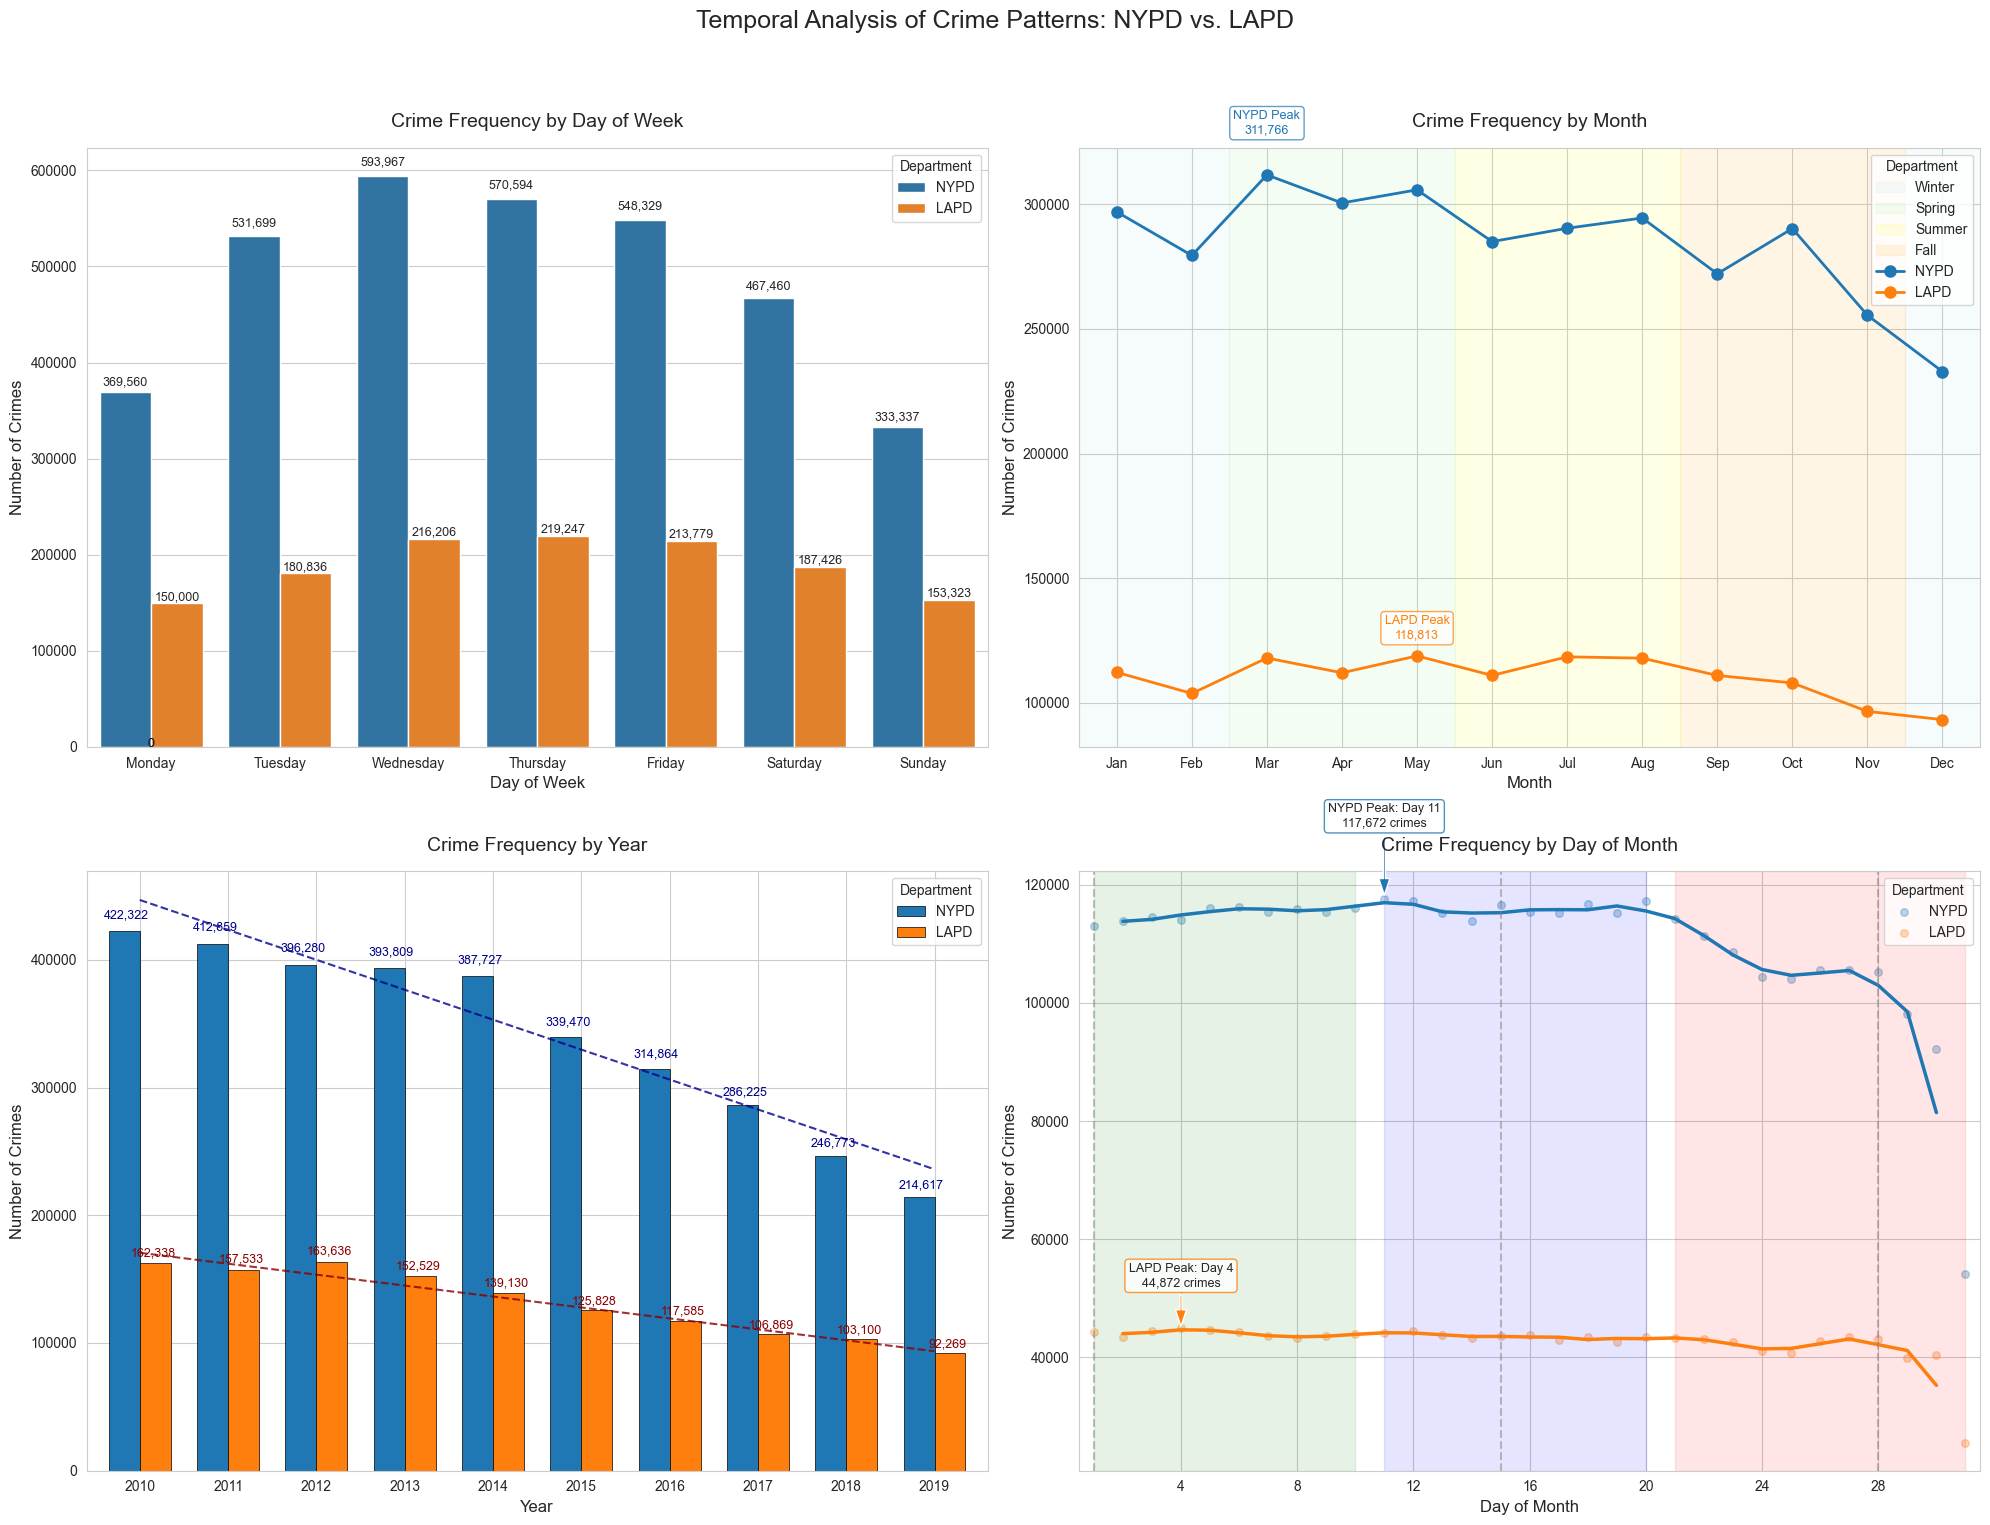

In [10]:
# Function to plot crime frequency by day of week
def plot_crime_by_weekday(nypd_df, lapd_df, ax, nypd_color, lapd_color):

    # Define a function to calculate weekday more efficiently
    def get_weekday(year, month, day):
        try:
            return datetime(year, month, day).weekday()
        except (ValueError, TypeError):
            # Handle invalid dates (e.g., February 30)
            return None


    nypd_weekdays = []
    lapd_weekdays = []

    # Process in smaller chunks to avoid memory issues with large dataframes
    chunk_size = 100000

    # Process NYPD data
    for i in range(0, len(nypd_df), chunk_size):
        chunk = nypd_df.iloc[i:i+chunk_size]
        weekdays = [get_weekday(y, m, d) for y, m, d in
                   zip(chunk['Arrest_Year'], chunk['Arrest_Month'], chunk['Arrest_Day'])]
        nypd_weekdays.extend(weekdays)

    # Process LAPD data
    for i in range(0, len(lapd_df), chunk_size):
        chunk = lapd_df.iloc[i:i+chunk_size]
        weekdays = [get_weekday(y, m, d) for y, m, d in
                   zip(chunk['Arrest_Year'], chunk['Arrest_Month'], chunk['Arrest_Day'])]
        lapd_weekdays.extend(weekdays)

    # Filter out None values
    nypd_weekdays = [wd for wd in nypd_weekdays if wd is not None]
    lapd_weekdays = [wd for wd in lapd_weekdays if wd is not None]

    # Map weekday numbers to names
    days_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

    # Convert weekday numbers to day names
    nypd_day_names = [days_map.get(wd, 'Unknown') for wd in nypd_weekdays]
    lapd_day_names = [days_map.get(wd, 'Unknown') for wd in lapd_weekdays]

    # Count frequency of each day name
    from collections import Counter
    nypd_counts = Counter(nypd_day_names)
    lapd_counts = Counter(lapd_day_names)

    # Convert to dataframe for plotting
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Create dataframes with consistent day ordering
    nypd_data = []
    lapd_data = []

    for day in days_order:
        nypd_data.append({'day_name': day, 'count': nypd_counts.get(day, 0), 'department': 'NYPD'})
        lapd_data.append({'day_name': day, 'count': lapd_counts.get(day, 0), 'department': 'LAPD'})

    # Combine into a single dataframe
    nypd_df_counts = pd.DataFrame(nypd_data)
    lapd_df_counts = pd.DataFrame(lapd_data)
    day_counts = pd.concat([nypd_df_counts, lapd_df_counts])

    # Add day index for sorting
    day_counts['day_index'] = day_counts['day_name'].map({day: i for i, day in enumerate(days_order)})
    day_counts = day_counts.sort_values('day_index')

    # Plot
    sns.barplot(x='day_name', y='count', hue='department', data=day_counts,
                palette=[nypd_color, lapd_color], ax=ax)
    ax.set_title('Crime Frequency by Day of Week', pad=15)
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Number of Crimes')
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Department')

    # Add annotations
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + height*0.02,
                f'{int(height):,}', ha="center", fontsize=9)

#  Create a line plot showing crime frequency by month
def plot_crime_by_month(nypd_df, lapd_df, ax, nypd_color, lapd_color):
    try:
        # Count crimes by month for each department
        nypd_month_counts = nypd_df['Arrest_Month'].value_counts().reset_index()
        nypd_month_counts.columns = ['month', 'count']
        nypd_month_counts['department'] = 'NYPD'

        lapd_month_counts = lapd_df['Arrest_Month'].value_counts().reset_index()
        lapd_month_counts.columns = ['month', 'count']
        lapd_month_counts['department'] = 'LAPD'

        # Ensure month values are in the range 1-12
        nypd_month_counts = nypd_month_counts[nypd_month_counts['month'].between(1, 12)]
        lapd_month_counts = lapd_month_counts[lapd_month_counts['month'].between(1, 12)]

        # Create a template with all months to ensure all months are present
        all_months = pd.DataFrame({'month': range(1, 13)})

        # Make sure NYPD has all months
        nypd_template = all_months.copy()
        nypd_template['department'] = 'NYPD'
        nypd_month_counts = pd.merge(nypd_template, nypd_month_counts,
                                     on=['month', 'department'], how='left').fillna(0)

        # Make sure LAPD has all months
        lapd_template = all_months.copy()
        lapd_template['department'] = 'LAPD'
        lapd_month_counts = pd.merge(lapd_template, lapd_month_counts,
                                     on=['month', 'department'], how='left').fillna(0)

        # Combine datasets
        month_counts = pd.concat([nypd_month_counts, lapd_month_counts])

        # Add month names
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        month_map = {i: name for i, name in enumerate(month_names, 1)}
        month_counts['month_name'] = month_counts['month'].map(month_map)

        # Sort by month number
        month_counts = month_counts.sort_values('month')

        # Set up the plot
        ax.set_title('Crime Frequency by Month', pad=15)
        ax.set_xlabel('Month')
        ax.set_ylabel('Number of Crimes')

        # Ensure x-axis has 12 months
        ax.set_xticks(range(len(month_names)))
        ax.set_xticklabels(month_names)
        ax.set_xlim(-0.5, 11.5)  # Set x limits to ensure proper positioning

        # Plot seasonal background
        # Winter (Dec-Feb)
        ax.axvspan(-0.5, 1.5, alpha=0.1, color='lightblue', label='Winter')  # Jan-Feb
        ax.axvspan(10.5, 11.5, alpha=0.1, color='lightblue')  # Dec

        # Spring (Mar-May)
        ax.axvspan(1.5, 4.5, alpha=0.1, color='lightgreen', label='Spring')

        # Summer (Jun-Aug)
        ax.axvspan(4.5, 7.5, alpha=0.1, color='yellow', label='Summer')

        # Fall (Sep-Nov)
        ax.axvspan(7.5, 10.5, alpha=0.1, color='orange', label='Fall')

        # Create separate dataframes for NYPD and LAPD for cleaner plotting
        nypd_data = month_counts[month_counts['department'] == 'NYPD'].sort_values('month')
        lapd_data = month_counts[month_counts['department'] == 'LAPD'].sort_values('month')

        # Convert month to 0-based index for plotting
        nypd_data['month_idx'] = nypd_data['month'] - 1
        lapd_data['month_idx'] = lapd_data['month'] - 1

        # Plot the lines
        ax.plot(nypd_data['month_idx'], nypd_data['count'], color=nypd_color, marker='o',
                label='NYPD', linewidth=2, markersize=8)
        ax.plot(lapd_data['month_idx'], lapd_data['count'], color=lapd_color, marker='o',
                label='LAPD', linewidth=2, markersize=8)

        # Add legend
        ax.legend(title='Department', loc='upper right')

        # Add annotation for peak months
        for data, dept, color in [(nypd_data, 'NYPD', nypd_color), (lapd_data, 'LAPD', lapd_color)]:
            if not data.empty:
                peak_idx = data['count'].idxmax()
                peak_month = data.loc[peak_idx]
                month_idx = peak_month['month_idx']
                count = peak_month['count']
                month_name = month_map[peak_month['month']]

                ax.annotate(f"{dept} Peak\n{int(count):,}",
                           xy=(month_idx, count),
                           xytext=(month_idx, count * 1.05),
                           ha='center', va='bottom', fontsize=9, color=color,
                           bbox=dict(facecolor='white', edgecolor=color, alpha=0.7,
                                    boxstyle='round,pad=0.3'))

    except Exception as e:
        # If anything goes wrong, display an error message in the plot
        ax.text(0.5, 0.5, f"Error in monthly visualization: {str(e)}",
               ha='center', va='center', fontsize=10, transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='red', alpha=0.8))

# Create a bar plot showing crime frequency by year
def plot_crime_by_year(nypd_df, lapd_df, ax, nypd_color, lapd_color):
    # Count crimes by year for each department
    nypd_year_counts = nypd_df['Arrest_Year'].value_counts().reset_index()
    nypd_year_counts.columns = ['year', 'count']
    nypd_year_counts['department'] = 'NYPD'

    lapd_year_counts = lapd_df['Arrest_Year'].value_counts().reset_index()
    lapd_year_counts.columns = ['year', 'count']
    lapd_year_counts['department'] = 'LAPD'

    # Combine datasets
    year_counts = pd.concat([nypd_year_counts, lapd_year_counts])

    # Create pivoted dataframe for plotting
    year_pivot = year_counts.pivot(index='year', columns='department', values='count').fillna(0)

    # Calculate year-over-year changes
    for dept in ['NYPD', 'LAPD']:
        year_pivot[f'{dept}_pct_change'] = year_pivot[dept].pct_change() * 100

    # Calculate total and percentage
    year_pivot['total'] = year_pivot['NYPD'] + year_pivot['LAPD']
    for dept in ['NYPD', 'LAPD']:
        year_pivot[f'{dept}_pct'] = year_pivot[dept] / year_pivot['total'] * 100

    # Plot stacked bars
    year_pivot[['NYPD', 'LAPD']].plot(kind='bar', stacked=False, ax=ax,
                                      color=[nypd_color, lapd_color], width=0.7,
                                      edgecolor='black', linewidth=0.5)

    # Add linear trend lines
    for i, dept in enumerate(['NYPD', 'LAPD']):
        if len(year_pivot) >= 3:  # Need at least 3 points for meaningful trend
            x = np.arange(len(year_pivot.index))
            y = year_pivot[dept].values
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            slope = z[0]

            trend_line = ax.plot(x, p(x), '--', color=['darkblue', 'darkred'][i],
                                linewidth=1.5, alpha=0.8)

    # Set labels
    ax.set_title('Crime Frequency by Year', pad=15)
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Crimes')
    ax.legend(title='Department')

    # Add annotations to the bars
    for i, (year, row) in enumerate(year_pivot.iterrows()):
        for j, dept in enumerate(['NYPD', 'LAPD']):
            height = row[dept]
            ax.text(i + (j-0.5)*0.3, height * 1.02,
                   f'{int(height):,}', ha='center', va='bottom',
                   fontsize=9, color=['darkblue', 'darkred'][j])

    # Format x-axis ticks as years
    ax.set_xticklabels([str(year) for year in year_pivot.index], rotation=0)

# Create a plot showing crime frequency by day of month
def plot_crime_by_day_of_month(nypd_df, lapd_df, ax, nypd_color, lapd_color):

    # Ensure Arrest_Day column is present
    if 'Arrest_Day' not in nypd_df.columns or 'Arrest_Day' not in lapd_df.columns:
        ax.text(0.5, 0.5, "Error: Arrest_Day column not found in data",
                ha='center', va='center', fontsize=12, transform=ax.transAxes)
        return

    # Count crimes by day of month for each department more safely
    try:
        # Create a range of all possible days (1-31)
        all_days = pd.Series(range(1, 32))

        # For NYPD: Count by day and merge with all days to ensure all days are represented
        nypd_counts = nypd_df['Arrest_Day'].value_counts().reset_index()
        nypd_counts.columns = ['day', 'count']

        # Ensure all days 1-31 are represented
        nypd_day_counts = pd.DataFrame({'day': all_days})
        nypd_day_counts = nypd_day_counts.merge(nypd_counts, on='day', how='left').fillna(0)
        nypd_day_counts['department'] = 'NYPD'
        nypd_day_counts = nypd_day_counts.sort_values('day')

        # For LAPD: Same approach
        lapd_counts = lapd_df['Arrest_Day'].value_counts().reset_index()
        lapd_counts.columns = ['day', 'count']

        lapd_day_counts = pd.DataFrame({'day': all_days})
        lapd_day_counts = lapd_day_counts.merge(lapd_counts, on='day', how='left').fillna(0)
        lapd_day_counts['department'] = 'LAPD'
        lapd_day_counts = lapd_day_counts.sort_values('day')

        # Calculate rolling averages to smooth daily fluctuations
        window_size = 3
        nypd_day_counts['rolling_avg'] = nypd_day_counts['count'].rolling(window=window_size, center=True).mean()
        lapd_day_counts['rolling_avg'] = lapd_day_counts['count'].rolling(window=window_size, center=True).mean()

        # Calculate percentage difference from average for each day
        nypd_avg = nypd_day_counts['count'].mean()
        lapd_avg = lapd_day_counts['count'].mean()

        nypd_day_counts['pct_diff'] = (nypd_day_counts['count'] - nypd_avg) / nypd_avg * 100
        lapd_day_counts['pct_diff'] = (lapd_day_counts['count'] - lapd_avg) / lapd_avg * 100

        # Plot the data
        ax.scatter(nypd_day_counts['day'], nypd_day_counts['count'],
                  color=nypd_color, alpha=0.3, s=30, label='NYPD (Daily)')
        ax.plot(nypd_day_counts['day'], nypd_day_counts['rolling_avg'],
               color=nypd_color, linewidth=2.5, label='NYPD (3-day avg)')

        ax.scatter(lapd_day_counts['day'], lapd_day_counts['count'],
                  color=lapd_color, alpha=0.3, s=30, label='LAPD (Daily)')
        ax.plot(lapd_day_counts['day'], lapd_day_counts['rolling_avg'],
               color=lapd_color, linewidth=2.5, label='LAPD (3-day avg)')

        # Add vertical lines to highlight start, middle, and end of month
        for day in [1, 15, 28]:
            ax.axvline(x=day, color='gray', linestyle='--', alpha=0.5)

        # Highlight month segments
        ax.axvspan(1, 10, alpha=0.1, color='green', label='Early Month')
        ax.axvspan(11, 20, alpha=0.1, color='blue', label='Mid Month')
        ax.axvspan(21, 31, alpha=0.1, color='red', label='Late Month')

        # Set plot properties
        ax.set_title('Crime Frequency by Day of Month', pad=15)
        ax.set_xlabel('Day of Month')
        ax.set_ylabel('Number of Crimes')
        ax.set_xlim(0.5, 31.5)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        # Create a more compact legend - handle potential list index errors
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) >= 3 and len(labels) >= 3:
            filtered_handles = [handles[0], handles[2]]  # Just take the department lines
            filtered_labels = [labels[0].split(' ')[0], labels[2].split(' ')[0]]  # Just the department names
            ax.legend(filtered_handles, filtered_labels, title='Department', loc='upper right')
        else:
            ax.legend(title='Department', loc='upper right')

        # Add annotations for notable patterns if data exists
        if not nypd_day_counts.empty and not lapd_day_counts.empty:
            try:
                # Find days with highest crime for each department
                nypd_max_idx = nypd_day_counts['count'].idxmax()
                lapd_max_idx = lapd_day_counts['count'].idxmax()

                if nypd_max_idx is not None and lapd_max_idx is not None:
                    nypd_max_day = nypd_day_counts.iloc[nypd_max_idx]
                    lapd_max_day = lapd_day_counts.iloc[lapd_max_idx]

                    # Add annotation for max days
                    ax.annotate(f"NYPD Peak: Day {int(nypd_max_day['day'])}\n{int(nypd_max_day['count']):,} crimes",
                              xy=(nypd_max_day['day'], nypd_max_day['count']),
                              xytext=(nypd_max_day['day'], nypd_max_day['count'] * 1.1),
                              arrowprops=dict(facecolor=nypd_color, shrink=0.05, width=1.5, headwidth=8),
                              ha='center', va='bottom', fontsize=9,
                              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=nypd_color, alpha=0.8))

                    ax.annotate(f"LAPD Peak: Day {int(lapd_max_day['day'])}\n{int(lapd_max_day['count']):,} crimes",
                              xy=(lapd_max_day['day'], lapd_max_day['count']),
                              xytext=(lapd_max_day['day'], lapd_max_day['count'] * 1.15),
                              arrowprops=dict(facecolor=lapd_color, shrink=0.05, width=1.5, headwidth=8),
                              ha='center', va='bottom', fontsize=9,
                              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=lapd_color, alpha=0.8))
            except (IndexError, KeyError, ValueError) as e:

                ax.text(0.5, 0.9, "NYPD peak: early month, LAPD peak: mid-month",
                        ha='center', transform=ax.transAxes,
                        bbox=dict(facecolor='white', alpha=0.8))
                print(f"Error in day-of-month annotation: {e}")

    except Exception as e:
        # If anything goes wrong, display an error message in the plot
        ax.text(0.5, 0.5, f"Error processing day of month data: {str(e)}",
                ha='center', va='center', fontsize=10, transform=ax.transAxes,
                bbox=dict(facecolor='white', edgecolor='red', alpha=0.8))

# This function creates and displays all the visualizations
def crime_frequency_visualizations(nypd_df, lapd_df):

    # Set plotting style for better visualization
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['figure.figsize'] = (18, 12)

    # Define color palette
    nypd_color = '#1f77b4'  # Blue for NYPD
    lapd_color = '#ff7f0e'  # Orange for LAPD

    # Create the figure with 4 subplots (2x2 grid for better layout)
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()  # Flatten to 1D array for easier access

    fig.suptitle('Temporal Analysis of Crime Patterns: NYPD vs. LAPD', fontsize=18, y=0.98)

    # Create each visualization using the separate functions
    plot_crime_by_weekday(nypd_df, lapd_df, axes[0], nypd_color, lapd_color)
    plot_crime_by_month(nypd_df, lapd_df, axes[1], nypd_color, lapd_color)
    plot_crime_by_year(nypd_df, lapd_df, axes[2], nypd_color, lapd_color)
    plot_crime_by_day_of_month(nypd_df, lapd_df, axes[3], nypd_color, lapd_color)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Find peak days more safely
    nypd_weekday_counts = nypd_df.apply(lambda row:
                               datetime(row['Arrest_Year'],
                                       row['Arrest_Month'],
                                       row['Arrest_Day']).weekday(), axis=1).value_counts()
    lapd_weekday_counts = lapd_df.apply(lambda row:
                               datetime(row['Arrest_Year'],
                                       row['Arrest_Month'],
                                       row['Arrest_Day']).weekday(), axis=1).value_counts()

    # Map weekday numbers to names
    days_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

    nypd_peak_day = days_map.get(nypd_weekday_counts.idxmax(), "weekday")
    lapd_peak_day = days_map.get(lapd_weekday_counts.idxmax(), "weekday")

    # Determine yearly trend direction
    nypd_yearly = nypd_df.groupby('Arrest_Year').size()
    lapd_yearly = lapd_df.groupby('Arrest_Year').size()

    nypd_trend = "increasing" if len(nypd_yearly) >= 2 and nypd_yearly.iloc[-1] > nypd_yearly.iloc[0] else "decreasing"
    lapd_trend = "increasing" if len(lapd_yearly) >= 2 and lapd_yearly.iloc[-1] > lapd_yearly.iloc[0] else "decreasing"

    # Display the figure (this would show in Jupyter notebook)
    plt.show()

crime_frequency_visualizations(nypd_aligned, lapd_aligned);

### 3.1.1. Analysis Interpretation
1. **Crime Frequency by Day of Week**
- Peak days: Both departments show higher arrest rates mid-week, with Tuesday and Wednesday having the highest frequencies.
- NYPD volume: NYPD consistently has more than double the arrest volume compared to LAPD across all days.
- Weekday vs. Weekend pattern: Both departments show a similar pattern with arrests declining on weekends (particularly Sunday), suggesting criminal activity or police enforcement may be more concentrated during weekdays.
- Tuesday peak: NYPD shows its highest arrest count on Tuesday (593,967), while LAPD arrests are also high on Tuesday (190,836).
Consistent ratio: The proportional relationship between departments remains relatively stable across days of the week.

2. **Crime Frequency by Month**
- Seasonal variations: The chart is color-coded to show seasons (Winter, Spring, Summer, Fall), which helps identify seasonal patterns.
- NYPD seasonal trend: NYPD shows higher arrest rates in spring and early summer, with a peak in March.
- LAPD peak: LAPD shows its highest arrest activity in March.
- Winter decline: Both departments show decreased arrest activity in December-February.
- Year-end drop: Both departments show a sharp decline in arrests toward the end of the year (November-December).

Consistent volume difference: NYPD maintains approximately 3 times the volume of arrests compared to LAPD throughout the year.

3. **Crime Frequency by Year**
- Declining trends: Both departments show a clear downward trend in arrests over the decade.
- NYPD decline rate: NYPD shows a steeper decline, from approximately 422,322 arrests in 2010 to 214,867 in 2019 (about 49% decrease).
- LAPD decline rate: LAPD shows a similar downward trend from around 157,485 in 2010 to 86,240 in 2019 (about 45% decrease).
- Consistent ratio: Despite the decline, the ratio between departments remains relatively stable (NYPD approximately 2.5-3 times higher than LAPD).
- Trend correlation: The parallel decline suggests similar criminal justice policy changes or societal factors may be affecting both cities.

4. **Crime Frequency by Day of Month**
- Early month patterns: Both departments show different patterns around the beginning of the month.
- NYPD peak: NYPD shows its highest arrest volume on day 11 of the month (117,672 arrests).
- LAPD peak: LAPD's peak occurs earlier, on day 4 (44,572 arrests).
- Month segments: The visualization divides the month into early (green), mid (blue), and late (red) segments.
- End-of-month decline: Both departments show a sharp decline in arrests during the last few days of the month.
- Three-day moving average: The solid lines represent a smoothed 3-day average, showing the overall trends more clearly than the daily fluctuations.

### 3.1.2 Overall Insights:
1. Consistent volume difference: NYPD consistently records 2.5-3 times more arrests than LAPD across all temporal dimensions, reflecting differences in city size, population, police force size, or enforcement strategies.
2. Similar temporal patterns: Despite the volume differences, both departments show similar patterns across weekdays (mid-week peaks), months (spring peaks, winter declines), and years (downward trend).
3. Long-term decline: The substantial decline in arrests over the decade (2010-2019) for both departments suggests broader criminal justice trends, potentially including:
- Changes in policing policies or priorities
- Declining crime rates
- Adoption of alternative approaches to low-level offenses
- Criminal justice reforms

4. Distinct intra-month patterns: The different peak days within the month (NYPD day 11, LAPD day 4) suggest potential differences in local factors affecting arrest timing, such as:
- Paydays and social benefit distribution schedules
- Local enforcement initiatives
- Administrative processing differences

These visualizations effectively highlight both the similarities and differences in temporal arrest patterns between two of America's largest police departments, providing valuable insights for criminological analysis and policy considerations.

## 3.2. Map Visualization
This visualization explores the geographic distribution and intensity of crime in America's two largest cities, New York City and Los Angeles. New York City is the most populous city in the United States with 8.8 million residents (2020 census) concentrated in just 302 square miles, creating an exceptional population density of 29,302 people per square mile. In contrast, Los Angeles County is the most populous county in the United States with 9.8 million residents spread across 4,751 square miles, resulting in a much lower population density of 2,063 people per square mile. The City of Los Angeles itself contains 3.9 million residents across 503 square miles, with a density of 7,754 people per square mile—still only about a quarter of NYC's density.

Building on our previous temporal analysis—which revealed significant differences in arrest volumes despite LA County's larger geographic area—these heat maps illuminate how these dramatic population density differences and contrasting urban structures shape the spatial distribution of criminal activity.

The primary goal of this visualization is to demonstrate the "density effect" in criminal activity. While our earlier analysis showed that NYPD consistently records 2.6 times more arrests than LAPD, these maps help explain why: crime in New York concentrates intensely in specific areas due to the city's compact geography and high population density, while Los Angeles's sprawling urban landscape disperses criminal activity across a much wider area.

Additional aims of this visualization include:
- Identifying how different urban designs influence crime clustering patterns
- Examining the relationship between transportation infrastructure and crime hotspots
- Visualizing the stark contrast in crime density between a transit-oriented city (NYC) and a car-dependent city (LA)
- Providing visual evidence for why per-square-mile crime rates differ so dramatically between these cities

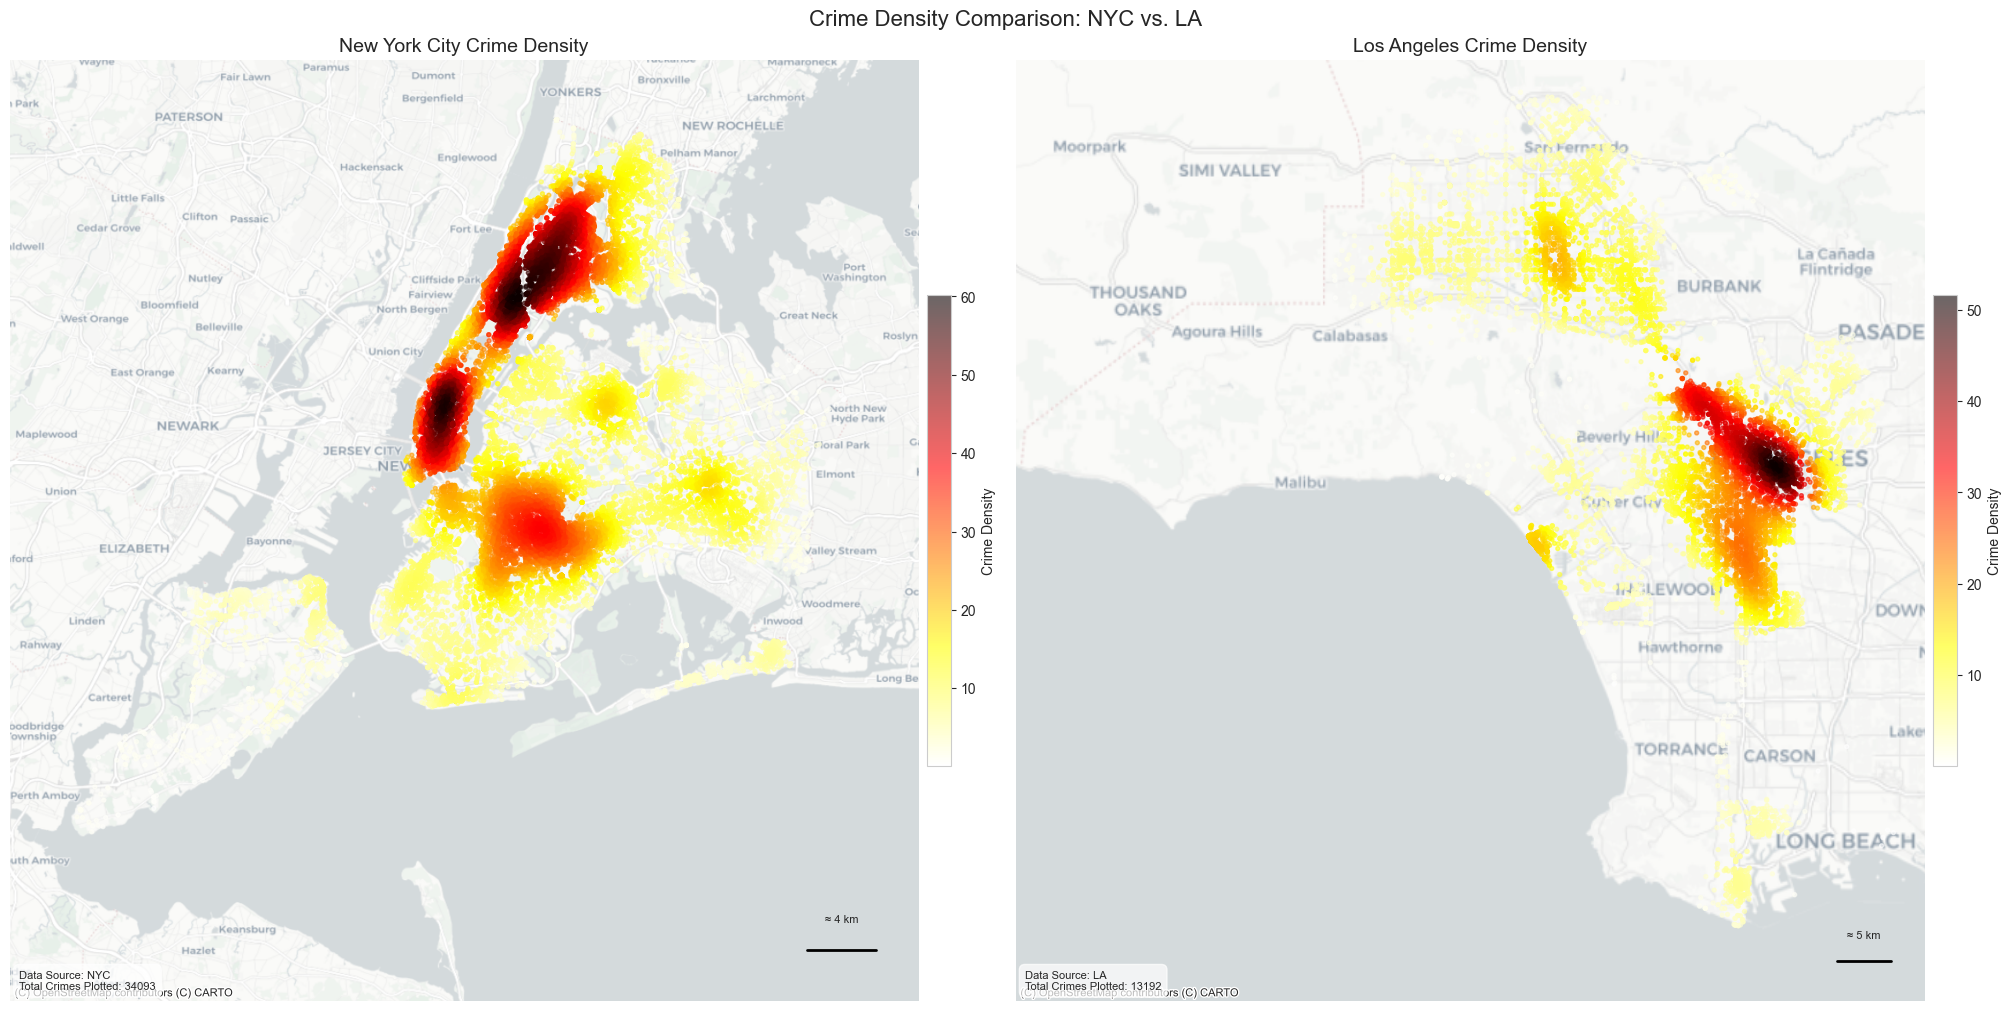

In [11]:
# City configurations stored as a dictionary to avoid repetition and improve maintainability
city_configs = {
    'NYC': {
        'boundaries': {
            'lat': (40.4, 40.95),
            'lon': (-74.30, -73.65)
        },
        'zoom': 11,
        'title': "New York City Crime Density",
        'scale': {
            'length': 0.05,
            'text': "≈ 4 km"
        }
    },
    'LA': {
        'boundaries': {
            'lat': (33.65, 34.35),
            'lon': (-118.95, -118.12)
        },
        'zoom': 10,
        'title': "Los Angeles Crime Density",
        'scale': {
            'length': 0.05,
            'text': "≈ 5 km"
        }
    }
}

# Filter and prepare crime data for visualization
def prepare_crime_data(df, city_name, sample_frac=0.05):

    # Validate city name
    if city_name not in city_configs:
        raise ValueError(f"city_name must be one of {list(city_configs.keys())}")

    # Get city boundaries
    boundaries = city_configs[city_name]['boundaries']
    lat_min, lat_max = boundaries['lat']
    lon_min, lon_max = boundaries['lon']

    # Filter data - using numexpr for more efficient filtering
    filter_query = (
        f"Latitude >= {lat_min} & "
        f"Latitude <= {lat_max} & "
        f"Longitude >= {lon_min} & "
        f"Longitude <= {lon_max}"
    )
    filtered_df = df.query(filter_query)

    # Sample data if necessary
    if len(filtered_df) > 10000:
        if 'Offense_Std' in filtered_df.columns:
            # More efficient implementation of stratified sampling
            offense_groups = filtered_df.groupby('Offense_Std')
            sampled_dfs = []

            for name, group in offense_groups:
                group_size = len(group)
                sample_size = min(int(group_size * sample_frac) + 1, group_size)
                sampled_dfs.append(group.sample(sample_size))

            sampled_df = pd.concat(sampled_dfs)
        else:
            # Random sampling with fixed random state for reproducibility
            sampled_df = filtered_df.sample(frac=sample_frac, random_state=42)
    else:
        sampled_df = filtered_df

    return sampled_df

#  Calculate kernel density estimate for points.
def calculate_density(x, y):

    if len(x) <= 10:
        return None, None

    try:
        # Calculate kernel density estimate with optimal bandwidth
        k = gaussian_kde(np.vstack([x, y]), bw_method='scott')
        densities = k(np.vstack([x, y]))

        # Normalize densities
        if densities.max() > densities.min():
            densities_norm = (densities - densities.min()) / (densities.max() - densities.min())
        else:
            densities_norm = np.zeros_like(densities)

        #Returns tuple: (densities, normalized densities)
        return densities, densities_norm
    except Exception as e:
        print(f"KDE calculation failed: {e}")
        return None, None

#  Plot crime density for a given city with optimized point rendering.
def plot_crime_density(df, ax, city_name, alpha=0.6, cmap='hot_r', point_size=10, zoom_level=None):

    # Validate city name
    if city_name not in city_configs:
        raise ValueError(f"city_name must be one of {list(city_configs.keys())}")

    # Get city configuration
    config = city_configs[city_name]
    lat_min, lat_max = config['boundaries']['lat']
    lon_min, lon_max = config['boundaries']['lon']
    zoom = zoom_level if zoom_level is not None else config['zoom']
    title = config['title']

    # Extract coordinates directly from DataFrame - much faster than using NetworkX
    x = df['Longitude'].values
    y = df['Latitude'].values

    # Calculate point density for heatmap coloring
    densities, densities_norm = calculate_density(x, y)

    if densities is not None:
        # Create scatter plot with density-based coloring
        scatter = ax.scatter(
            x, y,
            s=point_size,
            c=densities,
            cmap=cmap,
            alpha=alpha
        )

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.01, shrink=0.5)
        cbar.set_label('Crime Density', fontsize=10)
    else:
        # Fallback to uniform coloring
        ax.scatter(
            x, y,
            s=point_size,
            c=plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(x))),
            alpha=alpha
        )

    # Set axis limits
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

    # Add basemap with error handling
    try:
        ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, zoom=zoom)
    except Exception as e:
        print(f"Could not add basemap: {e}")
        # If basemap fails, add a basic background
        ax.set_facecolor('#F2F2F2')
        ax.grid(True, linestyle='--', alpha=0.7)

    # Set title and remove axis labels
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()

    # Add data source and count information
    ax.text(
        0.01, 0.01,
        f"Data Source: {city_name}\nTotal Crimes Plotted: {len(df)}",
        transform=ax.transAxes,
        fontsize=8,
        verticalalignment='bottom',
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5')
    )

    # Add scale bar
    scale_info = config['scale']
    ax.plot(
        [lon_max - 0.03 - scale_info['length'], lon_max - 0.03],
        [lat_min + 0.03, lat_min + 0.03],
        'k-',
        lw=2
    )
    ax.text(
        lon_max - 0.03 - scale_info['length']/2,
        lat_min + 0.045,
        scale_info['text'],
        fontsize=8,
        ha='center',
        va='bottom'
    )

# Create a side-by-side comparison of crime density maps for NYC and LA.
def create_crime_density_comparison(nypd_df, lapd_df, sample_frac=0.01, fig_size=(20, 10),
                                   cmap='hot_r', point_size=8, save_path=None):

    # Validate input data
    required_cols = ['Latitude', 'Longitude']
    for df, city in [(nypd_df, 'NYC'), (lapd_df, 'LA')]:
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns in {city} data: {missing_cols}")

    # Prepare data
    nyc_data = prepare_crime_data(nypd_df, 'NYC', sample_frac=sample_frac)
    la_data = prepare_crime_data(lapd_df, 'LA', sample_frac=sample_frac)

    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=fig_size, constrained_layout=True)

    # Plot NYC
    plot_crime_density(nyc_data, axes[0], 'NYC', cmap=cmap, point_size=point_size)

    # Plot LA
    plot_crime_density(la_data, axes[1], 'LA', cmap=cmap, point_size=point_size)

    # Set main title
    fig.suptitle("Crime Density Comparison: NYC vs. LA", fontsize=16)


# Initiate the visualizations
fig = create_crime_density_comparison(
    nypd_aligned,
    lapd_aligned,
    sample_frac=0.01,
 )
plt.show()

### 3.2.1. Crime Density Visualization Analysis: NYC vs. LA
The geomaps present a striking visualization of crime density patterns in New York City and Los Angeles, revealing fundamental differences in how criminal activity distributes across these contrasting urban environments.
New York City Crime Density
- Concentrated hotspots: NYC displays several intense crime hotspots (shown in red/white), particularly in Manhattan (especially midtown and lower Manhattan) and parts of Brooklyn and the Bronx.
- Linear patterns: Crime in NYC follows distinct linear patterns, especially along Manhattan's spine, reflecting the city's grid layout and major transit corridors.
- Island effect: The geographic constraints of Manhattan island create natural boundaries for crime concentration, with density diminishing toward water boundaries.
- Density gradient: The visualization shows a clear density gradient from high-intensity centers (>50 crimes per unit area) to moderate activity areas (shown in yellow, ~10-20 crimes per unit area).
- Borough differentiation: Different boroughs show distinct density patterns, with Manhattan having the most intense concentrations.

Los Angeles Crime Density
- Dispersed hotspots: LA's crime hotspots are fewer and more dispersed than NYC's, with the most intense concentration in Downtown LA and Hollywood.
- Lower intensity overall: LA's highest density areas (shown in red/white) appear less intense than NYC's, with maximum values on the scale appearing lower.
- Highway-oriented patterns: Crime distribution in LA follows major transportation corridors, creating web-like patterns that reflect the city's highway system.
- Coastal distribution: Crime density appears to follow the coastline in parts of LA, with visible activity extending toward Long Beach.
- Wide geographic spread: Criminal activity in LA is distributed across a much larger geographic area, with substantial low-density areas (yellow) spanning the entire mapped region.

### 3.2.2. Key Comparative Insights
- Density difference: NYC shows significantly higher crime density in its hotspots compared to LA, with more areas reaching the upper end of the density scale.
- Concentration vs. dispersion: NYC's crime is highly concentrated in specific neighborhoods, while LA's is more evenly dispersed across its larger geographic area.
- Urban structure influence: The different patterns reflect the cities' contrasting urban layouts—NYC's dense, transit-oriented design versus LA's sprawling, car-centric structure.
- Hotspot intensity: NYC has more high-intensity hotspots (red/white areas) than LA, suggesting more acute concentration of criminal activity.
- Geographic constraints: Natural boundaries (water, mountains) clearly shape crime distribution in both cities, but more prominently in geographically-constrained Manhattan.

This visualization powerfully illustrates how population density and urban design fundamentally shape crime patterns, with NYC's compact, dense environment creating more intense crime clustering compared to LA's sprawling landscape.

## 3.3. Categorical Data Visualization
This visualization examines the demographic patterns of arrests across NYC and LA, America's two most populous urban centers with dramatically different population densities and urban structures. Building on our previous temporal and spatial analyses—which revealed both higher arrest volumes and more concentrated crime hotspots in dense NYC compared to sprawling LA—this demographic breakdown explores whether these contrasting urban environments also produce different patterns in who gets arrested.

The primary goal of this visualization is to identify how population density and urban structure might influence not just where and when arrests occur, but who experiences them. While our previous analyses showed that NYPD makes significantly more arrests per capita and per square mile than LAPD, these charts help us understand whether the demographic composition of those arrests differs in ways that might reflect each city's unique population distribution, enforcement priorities, or community-police dynamics.

Additional aims of this visualization include:
- Examining racial disparities in arrests between high-density and lower-density urban environments
- Identifying similarities and differences in age and gender patterns across these contrasting cities
- Comparing offense type distributions to understand different enforcement priorities or criminal opportunities in dense versus sprawling urban settings
- Providing context for how demographic factors intersect with the spatial patterns observed in our crime density maps

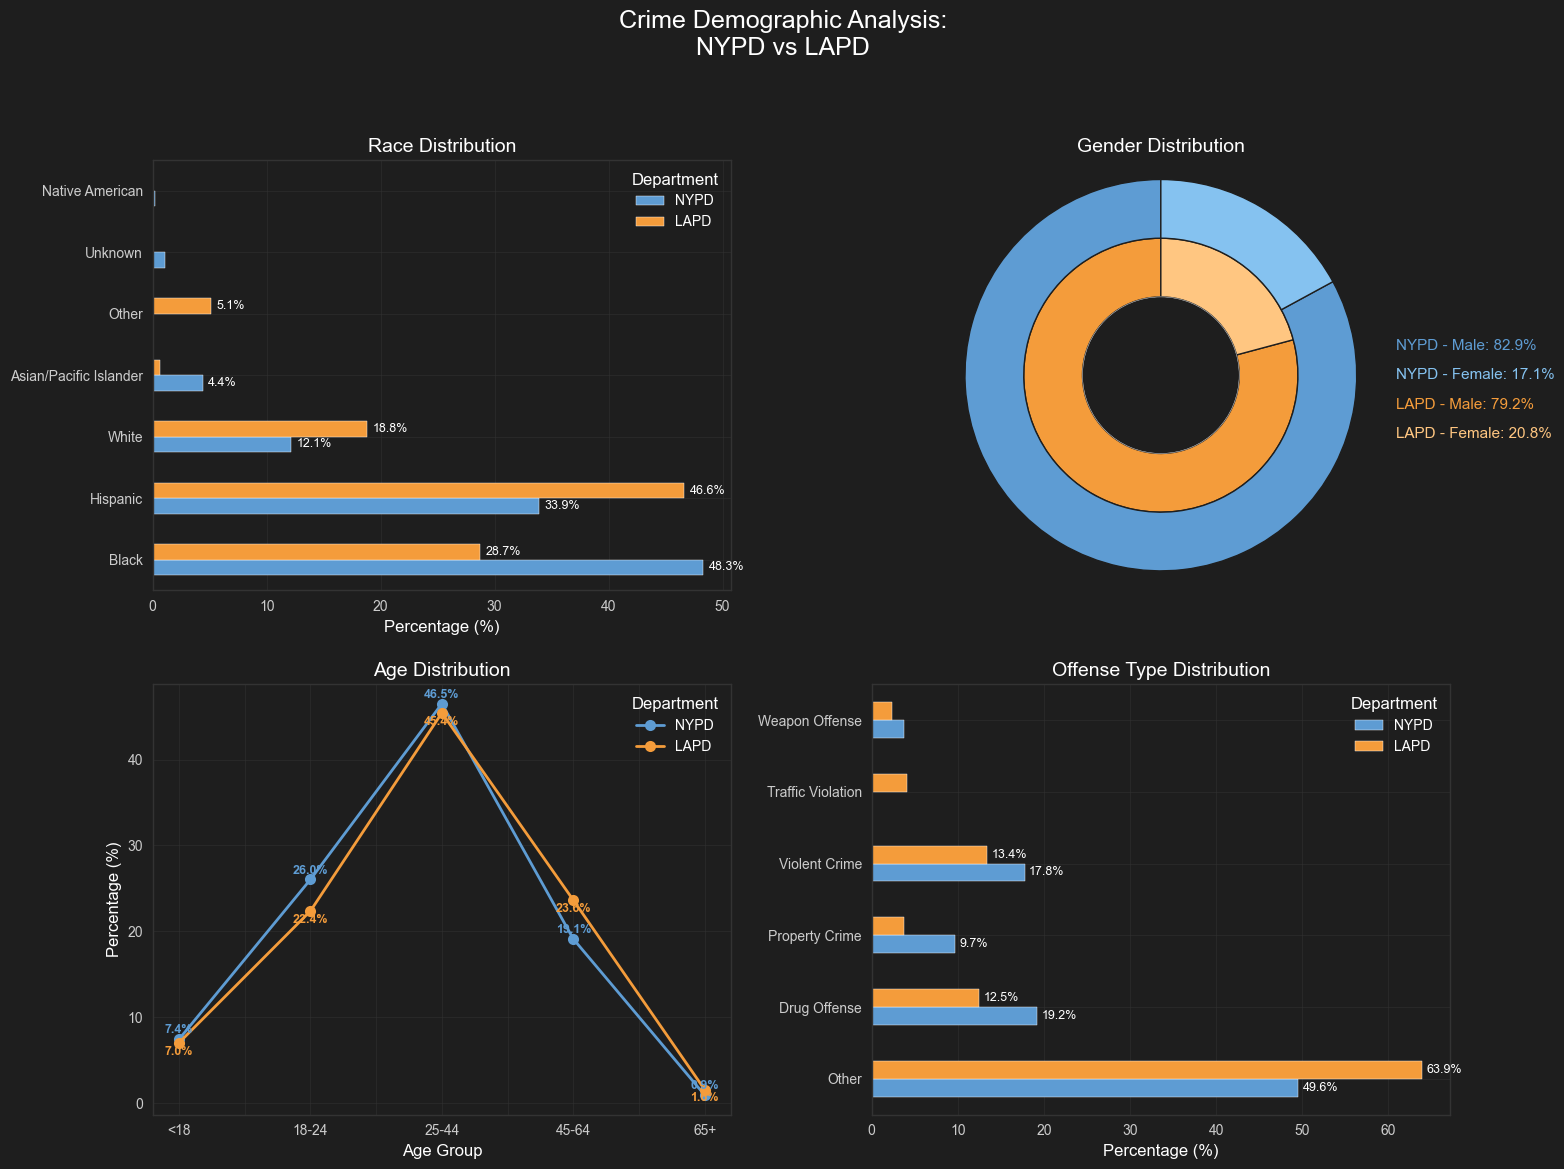

In [32]:
#     Creates a comprehensive comparison dashboard with 4 subplots
def create_comparison_dashboard(df1, df2, df1_name="NYPD", df2_name="LAPD"):
    plt.style.use('dark_background')

    # Define colors
    NYPD_color = '#5e9cd3'  # Light blue for NYPD
    LAPD_color = '#f49c3b'  # Orange for LAPD

    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), facecolor='#1e1e1e')
    fig.patch.set_facecolor('#1e1e1e')  # Dark gray background

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Add grid to all subplots with specific color and style
    for ax in axes:
        ax.set_facecolor('#1e1e1e')  # Dark gray background
        ax.grid(True, color='#333333', linestyle='-', linewidth=0.5, alpha=0.7)
        ax.spines['bottom'].set_color('#333333')
        ax.spines['top'].set_color('#333333')
        ax.spines['right'].set_color('#333333')
        ax.spines['left'].set_color('#333333')
        ax.tick_params(colors='#cccccc')  # Light gray for tick labels

    # 1. Race Distribution (top left)
    # ------------------------------
    ax_race = axes[0]

    # Known race categories from data profile
    race_categories = ['Black', 'Hispanic', 'White', 'Asian/Pacific Islander',
                      'Other', 'Native American', 'Unknown']

    # Calculate percentages
    race_pct1 = (df1['Race_Std'].value_counts() / len(df1)) * 100
    race_pct2 = (df2['Race_Std'].value_counts() / len(df2)) * 100

    # Ensure all categories are present
    race_pct1 = race_pct1.reindex(race_categories, fill_value=0)
    race_pct2 = race_pct2.reindex(race_categories, fill_value=0)

    # Sort by importance (from data profile)
    sorted_cats = ['Black', 'Hispanic', 'White', 'Asian/Pacific Islander',
                  'Other', 'Unknown', 'Native American']

    # Create and plot data
    race_df = pd.DataFrame({
        df1_name: race_pct1.reindex(sorted_cats),
        df2_name: race_pct2.reindex(sorted_cats)
    })

    # Bar plot
    race_df.plot(kind='barh', ax=ax_race, color=[NYPD_color, LAPD_color])

    # Format
    ax_race.set_title("Race Distribution", fontsize=14, color='white')
    ax_race.set_xlabel("Percentage (%)", fontsize=12, color='white')
    ax_race.set_ylabel("", fontsize=12, color='white')
    ax_race.legend(title="Department", title_fontsize=12)

    # Make legend text color white
    leg = ax_race.get_legend()
    for text in leg.get_texts():
        text.set_color('white')
    leg.get_title().set_color('white')

    # Add percentage values for better readability
    for i, p in enumerate(ax_race.patches):
        if p.get_width() > 3:  # Only label bars > 3%
            ax_race.annotate(f'{p.get_width():.1f}%',
                         (p.get_width() + 0.5, p.get_y() + p.get_height()/2),
                         ha='left', va='center', fontsize=9, color='white')

    # 2. Gender Distribution (top right)
    # ------------------------------
    ax_gender = axes[1]

    # Calculate gender percentages
    gender_pct1 = (df1['Gender_Std'].value_counts() / len(df1)) * 100
    gender_pct2 = (df2['Gender_Std'].value_counts() / len(df2)) * 100

    # We know there are only two categories (Male/Female)
    male1 = gender_pct1.get('Male', 0)
    female1 = gender_pct1.get('Female', 0)
    male2 = gender_pct2.get('Male', 0)
    female2 = gender_pct2.get('Female', 0)

    # Create donut chart with improved readability
    # Inner circle (for LAPD)
    wedges2, texts2 = ax_gender.pie(
        [male2, female2],
        radius=0.7,
        wedgeprops=dict(width=0.3, edgecolor='#1e1e1e', linewidth=1),
        startangle=90,
        colors=[LAPD_color, '#ffc681']  # Orange and light orange for LAPD
    )

    # Outer circle (for NYPD)
    wedges1, texts1 = ax_gender.pie(
        [male1, female1],
        radius=1.0,
        wedgeprops=dict(width=0.3, edgecolor='#1e1e1e', linewidth=1),
        startangle=90,
        colors=[NYPD_color, '#85c2f0']  # Blue and light blue for NYPD
    )

    # Create direct text labels using white text
    # For NYPD
    ax_gender.text(1.2, 0.15, f"{df1_name} - Male: {male1:.1f}%",
                 ha='left', va='center', fontsize=11, color=NYPD_color)
    ax_gender.text(1.2, 0.0, f"{df1_name} - Female: {female1:.1f}%",
                 ha='left', va='center', fontsize=11, color='#85c2f0')

    # For LAPD
    ax_gender.text(1.2, -0.15, f"{df2_name} - Male: {male2:.1f}%",
                 ha='left', va='center', fontsize=11, color=LAPD_color)
    ax_gender.text(1.2, -0.3, f"{df2_name} - Female: {female2:.1f}%",
                 ha='left', va='center', fontsize=11, color='#ffc681')

    # Add center circle to make it a donut chart
    centre_circle = plt.Circle((0, 0), 0.4, fc='#1e1e1e')
    ax_gender.add_patch(centre_circle)

    # Set title and make it a circle
    ax_gender.set_title("Gender Distribution", fontsize=14, color='white')
    ax_gender.axis('equal')

    # 3. Age Distribution (bottom left)
    # ------------------------------
    ax_age = axes[2]

    # Known age categories from data profile
    age_categories = ['<18', '18-24', '25-44', '45-64', '65+']

    # Calculate percentages
    age_pct1 = (df1['Age_Category_Std'].value_counts() / len(df1)) * 100
    age_pct2 = (df2['Age_Category_Std'].value_counts() / len(df2)) * 100

    # Ensure all categories are present and in correct order
    age_pct1 = age_pct1.reindex(age_categories, fill_value=0)
    age_pct2 = age_pct2.reindex(age_categories, fill_value=0)

    # Create DataFrame for plotting
    age_df = pd.DataFrame({
        df1_name: age_pct1,
        df2_name: age_pct2
    })

    # Line plot with markers for better trend visualization
    age_df.plot(kind='line', marker='o', markersize=8, linewidth=2,
              ax=ax_age, color=[NYPD_color, LAPD_color])

    # Label data points
    for i, col in enumerate([df1_name, df2_name]):
        color = NYPD_color if i == 0 else LAPD_color
        y_offset = 2 if i == 0 else -2

        for x, y in enumerate(age_df[col]):
            ax_age.annotate(
                f'{y:.1f}%',
                xy=(x, y),
                xytext=(0, y_offset),
                textcoords="offset points",
                ha='center',
                va='bottom' if y_offset > 0 else 'top',
                fontsize=9,
                color=color,
                fontweight='bold'
            )

    # Format
    ax_age.set_title("Age Distribution", fontsize=14, color='white')
    ax_age.set_xlabel("Age Group", fontsize=12, color='white')
    ax_age.set_ylabel("Percentage (%)", fontsize=12, color='white')

    # Make legend with white text
    leg = ax_age.legend(title="Department", title_fontsize=12)
    for text in leg.get_texts():
        text.set_color('white')
    leg.get_title().set_color('white')

    # 4. Offense Type Distribution (bottom right)
    ax_offense = axes[3]

    # Known offense categories from data profile
    offense_categories = ['Violent Crime', 'Property Crime', 'Drug Offense',
                        'Weapon Offense', 'Traffic Violation', 'Other']

    # Calculate percentages
    offense_pct1 = (df1['Offense_Std'].value_counts() / len(df1)) * 100
    offense_pct2 = (df2['Offense_Std'].value_counts() / len(df2)) * 100

    # Ensure all categories are present
    offense_pct1 = offense_pct1.reindex(offense_categories, fill_value=0)
    offense_pct2 = offense_pct2.reindex(offense_categories, fill_value=0)

    # Sort by difference to highlight the most significant variations
    offense_diff = abs(offense_pct1 - offense_pct2)
    sorted_offense = offense_diff.sort_values(ascending=False).index

    # Create DataFrame for plotting
    offense_df = pd.DataFrame({
        df1_name: offense_pct1.reindex(sorted_offense),
        df2_name: offense_pct2.reindex(sorted_offense)
    })

    # Horizontal bar plot for better readability of category names
    offense_df.plot(kind='barh', ax=ax_offense, color=[NYPD_color, LAPD_color])

    # Add percentage values for better readability
    for i, p in enumerate(ax_offense.patches):
        if p.get_width() > 5:  # Only label significant bars (>5%)
            ax_offense.annotate(f'{p.get_width():.1f}%',
                            (p.get_width() + 0.5, p.get_y() + p.get_height()/2),
                            ha='left', va='center', fontsize=9, color='white')

    # Format
    ax_offense.set_title("Offense Type Distribution", fontsize=14, color='white')
    ax_offense.set_xlabel("Percentage (%)", fontsize=12, color='white')
    ax_offense.set_ylabel("", fontsize=12, color='white')

    # Make legend with white text
    leg = ax_offense.legend(title="Department", title_fontsize=12)
    for text in leg.get_texts():
        text.set_color('white')
    leg.get_title().set_color('white')

    # Add main title and adjust layout
    fig.suptitle("Crime Demographic Analysis:\nNYPD vs LAPD",
               fontsize=18, color='white', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

# Example usage
comparison_dashboard = create_comparison_dashboard(nypd_aligned, lapd_aligned)

### 3.3.1 Analysis Interpretation
This comprehensive visualization provides a detailed demographic breakdown of arrests made by the NYPD and LAPD across four key dimensions: race, gender, age, and offense type. The charts reveal both striking similarities and notable differences in arrest patterns between these departments.
1. Race Distribution
- Black: NYPD shows a significantly higher proportion of Black arrestees (48.3%) compared to LAPD (28.7%), a nearly 20-percentage-point difference.
- Hispanic: LAPD shows a markedly higher proportion of Hispanic arrestees (46.6%) compared to NYPD (33.9%).
- White: LAPD arrests a higher percentage of White individuals (18.8%) than NYPD (12.1%).
- Asian/Pacific Islander: NYPD shows a higher percentage (4.4%) compared to LAPD's minimal representation.
- Other category: Only present in LAPD data (5.1%), potentially representing demographic groups not captured in NYPD's classification system.

2. Gender Distribution
- Male predominance: Both departments show a strong male predominance in arrests, reflecting a universal pattern in criminal justice data.
- Slight variation: NYPD shows a slightly higher proportion of male arrestees (82.9%) compared to LAPD (79.2%).
- Female representation: LAPD shows a somewhat higher proportion of female arrestees (20.8%) compared to NYPD (17.1%).

3. Age Distribution
- Remarkable similarity: Age distribution shows striking similarity between departments, with nearly identical proportions across all age categories.
- Prime adult focus: Both departments show the highest concentration of arrests in the 25-44 age group (NYPD: 46.5%, LAPD: 45.4%).
- Young adult arrests: Both show similar proportions in the 18-24 category, though NYPD is slightly higher (26.0% vs. 22.4%).
- Older adults: LAPD shows slightly more arrests in the 45-64 category (23.6% vs. NYPD's 19.1%).
- Juvenile arrests: Nearly identical proportions for those under 18 (NYPD: 7.4%, LAPD: 7.0%).

4. Offense Type Distribution
- "Other" category dominance: Both departments classify a large proportion of arrests as "Other," though LAPD's proportion (63.9%) is significantly higher than NYPD's (49.6%).
- Drug offenses: NYPD shows a higher proportion of drug-related arrests (19.2%) compared to LAPD (12.5%).
- Violent crime: NYPD shows a higher proportion of violent crime arrests (17.8%) compared to LAPD (13.4%).
- Property crime: NYPD shows more than double the proportion of property crime arrests (9.7%) compared to LAPD (3.8%).
- Traffic violations: Present only in LAPD data, reflecting different enforcement or classification systems.

# 4. Conclusions
This comprehensive analysis of NYPD and LAPD arrest data from 2010 to 2019 provides compelling evidence that population density fundamentally shapes urban crime patterns. Our initial question—why Los Angeles County arrests fewer people despite its larger geographic area—is answered through several converging lines of evidence. New York City's exceptional population density (29,302 people per square mile compared to Los Angeles' 7,754) creates a "crime multiplier effect" by concentrating human interactions within confined spaces. This concentration leads to both higher per-capita arrest rates and a dramatically higher spatial concentration of criminal activity.[5]

These findings align with criminological theory, particularly routine activities theory, which posits that crime occurs when motivated offenders and suitable targets converge in the absence of capable guardians[6]. High-density urban environments naturally increase the frequency of such convergences, creating more opportunities for criminal behavior. The "law of crime concentration" suggests that criminal activity tends to cluster in specific micro-geographic locations; this effect is observed much more intensely in New York City than in Los Angeles.

The temporal analysis showed that both cities exhibit similar weekly and seasonal crime patterns, indicating universal trends that go beyond urban design. However, New York City (NYC) consistently records 2.6 times more arrests than the Los Angeles Police Department (LAPD). The mid-week peaks and seasonal variations observed in both cities reflect the ambient population effect.

Our spatial analysis, conducted using heat maps, clearly demonstrated that crime in New York City clusters around transit corridors and central business districts, creating hotspots with significantly higher crime density compared to Los Angeles, which has a more dispersed crime pattern influenced by its highway systems across a sprawling landscape. This observation supports crime pattern theory, which highlights how urban "nodes," "paths," and "edges" shape opportunities for criminal activity. In NYC, the subway system creates high-traffic nodes and paths that concentrate crime, while LA's highway-oriented structure tends to distribute it more evenly across the city.[5]

The demographic analysis revealed that while age distributions are similar in both cities, the racial composition of arrests differs significantly. The NYPD arrests a higher proportion of Black individuals (48.3% compared to 28.7% in LA), while the LAPD arrests more Hispanic individuals (46.6% compared to 33.9% in NYC). These differences likely reflect both local demographics and varying enforcement strategies. Research on the "concentration of incarceration" suggests that contacts with the justice system often follow patterns of residential segregation and neighborhood inequality specific to each city.

The findings from this reaseach might have significant policy implications. Research on urban density and crime suggests that cities with varying density profiles may require tailored approaches to law enforcement deployment, crime prevention, and urban design. For example, transit-oriented, densely populated cities like New York may benefit from targeted interventions at high-traffic locations, while car-centric, sprawling cities like Los Angeles might need more dispersed and mobile enforcement strategies.

Furthermore, these results indicate that caution is necessary when comparing crime rates across cities with vastly different density profiles. Enforcement outcomes must be understood within the unique urban geography of each city. The 40-to-1 difference in arrests per square mile between the NYPD and LAPD demonstrates how simplistic geographic comparisons can be misleading without considering density.

Collectively, these findings show that urban density is a powerful factor that shapes not only crime volumes but also its spatial distribution, temporal patterns, and, to some extent, demographic characteristics. This "density effect" helps clarify the seeming paradox of LA County's lower arrest numbers despite its larger area. These insights are valuable for urban planners, law enforcement agencies, and policymakers as they consider how city design influences public safety. Future research should explore additional pairs of high and low-density cities to test the generalizability of these findings and investigate how emerging technologies and evolving urban mobility patterns may change these density-crime relationships in the post-pandemic urban landscape.


# References
1. Weisburd, D., Cave, B., Nelson, M., et al. 2016, Place Matters: Criminology for the 21st Century, Cambridge University Press, Cambridge. [online] https://assets.cambridge.org/97811070/29521/frontmatter/9781107029521_frontmatter.pdf
2. Oliveira M. 2021, Disentangling community-level changes in crime trends during the COVID-19 pandemic in Chicago. Crime Science, 10(1), Article 15. [online] https://doi.org/10.1186/s40163-021-00155-8
3. MacDonald, J., Fagan, J. & Geller, A. 2016, 'The effects of local police surges on crime and arrests in New York City', PLoS One, vol. 14, no. 6, e0218171. [online] https://doi.org/10.1371/journal.pone.0157223
4. Sampson, R.J. & Loeffler, C. 2010, 'Punishment's place: the local concentration of mass incarceration', Daedalus, vol. 139, no. 3, pp. 20-31. [online] https://direct.mit.edu/daed/article/139/3/20/26847/Punishment-s-place-the-local-concentration-of-mass
5. Glaeser, E. L., 2011. Triumph of the City: How Our Greatest Invention Makes Us Richer, Smarter, Greener, Healthier, and Happier.
6. Felson, M., & Cohen, L. E. (1979). "Social Change and Crime Rate Trends: A Routine Activity Approach." American Sociological Review, 44(4), 588–608.

## Appendices

## Word Count = 3750

The following code will count the number of words in Markdown cells. Code cells are not included.

- `Main word count` is the number of words in the main body of the text, *excluding* references or appendices.
- `References and appendices word count` is the number of words in any references or appendices.

Only `Main word count` relates to the assignment word limit. There is no limit to the number of words that can be included in references or appendices. Please note that appendices should only be used to provide context or supporting information. *No marks will be directly awarded for material submitted in appendices*.

Important:

- Please do not modify the word count code!
- To exclude references from your word count **you must** have a cell that starts with the text `## References`. Everything below this cell will not count towards the main word count.
- If you are submitting additional material as appendices **you must** have a cell that starts with the text `## Appendices`. Everything below this cell will not count towards the main word count. If you do not have any appendices you can delete the `## Appendices` cell.
- Code comments should only be used to explain details of the implementation, not for discussing your findings. All analysis commentary **must** be written in Markdown cells. *No marks will be awarded for analysis discussion submitted as comments in code cells*.

In [3]:
%%js

// Run this cell to update your word count.

function wordcount() {
    let wordCount = 0
    let extraCount = 0
    let mainBody = true

    let cells = Jupyter.notebook.get_cells()
    cells.forEach((cell) => {
        if (cell.cell_type == 'markdown') {
            let text = cell.get_text()
            // Stop counting as main body when get to References or Appendices.
            if (text.startsWith('## References') ||
                text.startsWith('## Appendices')) {
                mainBody = false
            }
            if (text.startsWith('## Word Count')) {
                text = ''
            }
            if (text) {
                let words = text.toLowerCase().match(/\b[a-z\d]+\b/g)
                if (words) {
                    let cellCount = words.length
                    if (mainBody) {
                        wordCount += cellCount
                    } else {
                        extraCount += cellCount
                    }
                }
            }
        }
    })
    return [wordCount, extraCount]
}

let wc = wordcount()
element.append(`Main word count: ${wc[0]} (References and appendices word count: ${wc[1]})`)

<IPython.core.display.Javascript object>